# Setup

In [1]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 150)

import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import seaborn as sns


import nltk
from nltk.collocations import *

import networkx as nx

import matplotlib.pyplot as plt

# There is a lot of changes in Plotly nowadays. Perhaps some modifications of the code will be needed at some point
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.offline.init_notebook_mode(connected=True)

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

!pip install sddk # our own package for working with sciencedata.dk
from  sddk import * # import all functions

### it takes for a while, because it also imports quite large morpheus dictionary
!pip install anda ### our own package for working with ancient data of various kind
from anda.gr import *

In [0]:
### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:

sh_inaf = gc.open_by_url("https://docs.google.com/spreadsheets/d/1eExXAkrKiPp421FPsOsKhQtp9gYOs7xtVA0NkIQ-8Ko/edit?usp=sharing")

# RESULTS SPREADSHEET
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1aRNUQeci2aWApkXk69OI_9YINL8YXXnornKkVi0LZeE/edit?usp=sharing")
# WORKING DATA SPREADSHEET
#sh_working = gc.open_by_url("https://docs.google.com/spreadsheets/d/12wOBjRGgoBSIXoN_9cbG32eKA8UAWwWB9YCvpb8xFnU/edit?usp=sharing")

In [6]:
conf = configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Data import and sub-corpora formation

In [0]:
LG_data_cleaned = read_file("SDAM_data/OGL/AGT.json", "df", conf)

In [6]:
### number of documents
len(LG_data_cleaned)

1182

In [7]:
LG_data_cleaned.head(3)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,theos_count,lemmatized_sentences,num_of_sents,theosTF
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica; Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},2.5,pagan,38822,"[παλαιγενής, κλέος, φώς/φάος, στόμα, πέτρα, βα...",12880,62,"[[παλαιγενής, κλέος, φώς/φάος, στόμα, πέτρα, β...",3019,0.001597
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War; Historiae in two volumes,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν ...,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,150160,"[πόλεμος, ἀλλήλων, μέγας, ἀξιόλογος, ἀμφότερος...",33162,38,"[[πόλεμος, ἀλλήλων, μέγας, ἀξιόλογος, ἀμφότερο...",5803,0.000253
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers; Lives of Eminen...,ΒΙΩΝ ΚΑΙ ΓΝΩΜΩΝ ΤΩΝ ΕΝ ΦΙΛΟΣΟΦΙΑΙ ΕΥΔΟΚΙΜΗΣΑΝΤ...,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,pagan,111053,"[φιλοσοφία, ἔργον, Φᾶσις/φάσις, βάρβαρος, εἰκο...",25885,174,"[[φιλοσοφία, ἔργον, Φᾶσις/φάσις, βάρβαρος], [ε...",8290,0.001567


In [0]:
### ### let's make this last change!!!
LG_data_cleaned["lemmata"] = LG_data_cleaned.apply(lambda row: " ".join(row["lemmata"]).replace("θεός/θεά/θέα", "θεός").split(), axis=1)
LG_data_cleaned["lemmatized_sentences"] = LG_data_cleaned.apply(lambda row: [" ".join(sentence).replace("θεός/θεά/θέα", "θεός").split() for sentence in row["lemmatized_sentences"]], axis=1)
###.count("θεός") + row["lemmata"].count("θεός/θεά/θέα"

# concordance-row and concordance frequency distribution (CRFD)

In [0]:
### sligthly modified functions from nltk

from nltk import ConcordanceIndex
class ConcordanceIndex2(ConcordanceIndex):
    def create_concordance(self, word, width):
        "Returns a list of contexts for @word with a context <= @token_width"
        half_width = width // 2
        contexts = []
        for i, token in enumerate(self._tokens):
            if token == word:
                start = i - half_width if i >= half_width else 0
                context = self._tokens[start:i + half_width + 1]
                contexts.append(context)
        return contexts
    def create_concordance_raw_words(self, word, width):
        "Returns a list of contexts for @word with a context <= @token_width"
        half_width = width // 2
        contexts = []
        for i, token in enumerate(self._tokens):
            if token == word:
                start = i - half_width if i >= half_width else 0
                context = self._tokens[start:i + half_width + 1]
                contexts.extend(context[:half_width] + context[half_width + 1:])
        return contexts

def conc_from_list(text, word, width):
    c = ConcordanceIndex2(text)
    return c.create_concordance(word, width)

def conc_words_from_list(text, word, width):
    c = ConcordanceIndex2(text)
    return c.create_concordance_raw_words(word, width)

def most_common_conc_words(list_of_words, term, width):
  """returns list of sorted by MI"""
  doc_conc_list = conc_words_from_list(list_of_words, term, width)
  most_common_words = nltk.FreqDist(doc_conc_list).most_common()
  N = len(list_of_words) ### number of words in the subcorpus
  x_count = list_of_words.count(term)
  try: Px = x_count / N ### rel.freq. of the key term
  except: Px = 0
  most_common_words_data = []
  for tup in most_common_words:
    TFconc = tup[1] / len(doc_conc_list) ### term frequency (TF)
    y_count = list_of_words.count(tup[0])
    TFdoc = y_count / N
    MI = TFconc / TFdoc
    most_common_words_data.append([tup[0], lemma_translator(tup[0]), tup[1], y_count, np.round(TFconc, 7) , np.round(TFdoc, 7), MI])
  return sorted(tuple(most_common_words_data), key=lambda element: element[6], reverse=True)

def most_common_conc_from_row(row, column, term, width):
  """returns list of sorted by MI"""
  doc_text_list = row[column]
  return most_common_conc_words(doc_text_list, term, width)

def extract_sentences_with_term(row, term):
  doc_text_list = row["lemmata"]
  sentence_words_list = []
  for sentence in [sentence for sentence in row["lemmatized_sentences"] if term in sentence]:
    sentence_words_list.extend(sentence)
  most_common_words = nltk.FreqDist(sentence_words_list).most_common()
  N = len(doc_text_list) ### number of words in the subcorpus
  x_count = doc_text_list.count(term)
  try: Px = x_count / N ### rel.freq. of the key term
  except: Px = 0
  most_common_words_data = []
  for tup in most_common_words:
    TFconc = tup[1] / len(sentence_words_list) ### term frequency (TF)
    y_count = doc_text_list.count(tup[0])
    TFdoc = y_count / N 
    try: MI = TFconc / TFdoc
    except: MI = 0
    most_common_words_data.append([tup[0], lemma_translator(tup[0]), tup[1], y_count, np.round(TFconc, 7) , np.round(TFdoc, 7), MI])
  return sorted(tuple(most_common_words_data), key=lambda element: element[6], reverse=True)

In [10]:
### we will test our algorithms on a data sample of 10 documents:
random.seed(30) ### firstly generated on Oct 9, 15:24
randomly_selected_works = [random.randint(0,len(LG_data_cleaned)) for i in range(10)]
LG_testing_sample = LG_data_cleaned.iloc[randomly_selected_works]
###set_with_dataframe(sh.add_worksheet("LG_sample_FIXED", cols=1, rows=1), LG_testing_sample.drop(["lemmata", "string"], axis=1))
LG_testing_sample

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,theos_count,lemmatized_sentences,num_of_sents,theosTF
1230,tlg2034.tlg003.1st1K-grc1.xml,Porphyrius,De abstinentia; Opuscula Tria,"ΒΙΒΔΙΟΝ ΠΡΩΤΟΝ Τῶν πρὸς ἡμᾶς ἡκόντων, ὦ Φίρμε,...",tlg2034,tlg2034.tlg003,A.D. 3,2.5,{'2.5': 1},2.5,pagan,35999,"[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέας...",9207,200,"[[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέα...",1658,0.005556
649,tlg0074.tlg005.perseus-grc1.xml,Arrian,Tactica; Arriani Nicomediensis Scripta Minora,"ὁ Πύρρου παῖς καὶ Κλέαρχος, οὐχ ὁ τῶν μυρίων Ἑ...",tlg0074,tlg0074.tlg005,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,9006,"[παῖς/πᾶς, μυρίος, βασιλεύς, μέγας, πόλεμος, σ...",2494,0,"[[παῖς/πᾶς, μυρίος, βασιλεύς], [μέγας, πόλεμος...",411,0.000000
61,tlg0007.tlg044.perseus-grc2.xml,Plutarch,Machine readable text; Agesilaus; Plutarch's L...,Ἀγησίλαος Ἀρχίδαμος ὁ Ζευξιδάμου βασιλεύσας ἐπ...,tlg0007,tlg0007.tlg044,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,10924,"[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτηρ...",2618,10,"[[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτη...",427,0.000915
487,tlg0057.tlg059.1st1K-grc1.xml,Galen,De differentiis pulsuum; Claudii Galeni Opera ...,ΓΑΛΗΝΟΥ ΠΕΡΙ ΔΙΑΦΟΡΑΣ ΣΦΥΓΜΩΝ ΛΟΓΟΣ Α. Εὐξαίμη...,tlg0057,tlg0057.tlg059,A.D. 2,1.5,{'1.5': 1},2.5,pagan,42856,"[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρία...",11750,4,"[[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρί...",1882,0.000093
583,tlg0062.tlg017.perseus-grc1.xml,Lucian,Juppiter confuatus; Machine readable text; Works,"Κυνίσκος ἐγὼ δέ, ω Ζεῦ, τὰ μὲν τοιαῦτα οὑκ ἐνο...",tlg0062,tlg0062.tlg017,A.D. 2,1.5,{'1.5': 1},1.5,pagan,2338,"[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια,...",499,5,"[[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια...",133,0.002139
99,tlg0007.tlg082b.perseus-grc4.xml,Plutarch,Λακαινῶν ἀποφθάγματα; Moralia,"Ἀργιλεωνίδος Ἀργιλεωνὶς ἡ Βρασίδου μήτηρ, τελε...",tlg0007,tlg0007.tlg082,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,1186,"[μήτηρ, υἱός, κάλως/καλός, ἄξιος, υἱός, ἐκεῖνο...",289,0,"[[μήτηρ, υἱός], [κάλως/καλός, ἄξιος, υἱός], [ἐ...",74,0.000000
932,tlg0540.tlg029.perseus-grc2.xml,Lysias,Against Philocrates; Lysias with an English tr...,"ὁ μὲν ἀγὼν οὗτος, ὦ ἄνδρες δικασταί, ἐρημότερο...",tlg0540,tlg0540.tlg029,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-4.5,pagan,679,"[ἀνήρ, δικαστής, ἐρῆμος, πολύς, ἡμός/ἐμός/ἁμός...",140,0,"[[ἀνήρ, δικαστής, ἐρῆμος], [πολύς], [ἡμός/ἐμός...",37,0.000000
889,tlg0530.tlg006.1st1K-grc1.xml,pseudo-Galen,Ad Gaurum quomodo animetur fetus; Die neuplato...,[Γαληνοῦ] πρὸς Γαῦρον περὶ τοῦ πῶς ἐμψυχοῦται ...,tlg0530,tlg0530.tlg006,p. A.D. 2,3.0,"{'14.5': 0.0001, '13.5': 0.0002, '12.5': 0.000...",2.5,pagan,9604,"[ἔμβρυον, σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀπορ...",2512,6,"[[ἔμβρυον], [σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀ...",318,0.000625
300,tlg0017.tlg003.perseus-grc1.xml,Isaeus,On The Estate Of Pyrrhus ; Isaeus with an Engl...,Πύρρου τὸν ἕτερον ltτῶνgt τῆς ἀδελφῆς υἱῶν υἱο...,tlg0017,tlg0017.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",NaN,pagan,4538,"[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰκ...",1027,0,"[[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰ...",257,0.000000
166,tlg0010.tlg008.perseus-grc2.xml,Isocrates,Against the Sophists; Machine readable text; I...,εἰ πάντες ἤθελον οἱ παιδεύειν ἐπιχειροῦντες ἀλ...,tlg0010,tlg0010.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,1330,"[πᾶς, ἀληθής, μέγας, ὑπόσχεσις, κακός, ἰδιώτης...",311,0,"[[πᾶς, ἀληθής, μέγας, ὑπόσχεσις, κακός, ἰδιώτη...",43,0.000000


In [0]:
LG_testing_sample["conc_theos"] = LG_testing_sample.apply(lambda row: most_common_conc_words(row["lemmata"], "θεός", 7), axis=1)

# Morality Indicators
In the pilot study, the moral indicitors have been coded manually from most frequent terms.

In this version. we will instead use the Moral Foundation Dictionary avaialable from [here](https://moralfoundations.org/other-materials/) and preprocessed in another script.

In [8]:
moral_dict_df = get_as_dataframe(sh.worksheet("moral-indicators"))
moral_dict_df.tail(10)

,raw,category,term,var1
326,proper\t\t\t11,11,proper,True
327,laudable\t\t11,11,laudable,True
328,correct\t\t\t11,11,correct,True
329,wrong*\t\t\t11,11,wrong*,False
330,evil\t\t\t11,11,evil,False
331,immoral*\t\t11,11,immoral*,False
332,bad\t\t\t11,11,bad,False
333,offend*\t\t\t11,11,offend*,False
334,offensive*\t\t11,11,offensive*,False
335,transgress*\t\t11,11,transgress*,False


In [9]:
moral_indicators = moral_dict_df[moral_dict_df["var1"]==True]["term"].tolist()
moral_indicators = [term.replace(" ", "").partition("*")[0] for term in moral_indicators] 
print(moral_indicators)

['righteous', 'moral', 'ethic', 'value', 'upstanding', 'good', 'goodness', 'principle', 'blameless', 'exemplary', 'lesson', 'canon', 'doctrine', 'noble', 'worth', 'ideal', 'praiseworthy', 'commendable', 'character', 'proper', 'laudable', 'correct']


In [0]:
greek_indicators_filtered = ['εὐθημοσύνη', 'πάνδικος', 'κόλασις', 'εὐσεβής', 'εὐόργητος', 'ἀγαθοποιός', 'εὐδαιμονία', 'ἀρετή', 'θεμιτός', 'εὐνομία', 'ἀμώμητος', 'εὔλογος', 'τίμιος', 'τιμητέος', 'εὐδοκίμησις', 'ἐσθλός', 'εὐπρεπής', 'ἀγαθοεργός', 'ἀξιόπιστος', 'δόκιμος/δοκιμή', 'ἀμύμων', 'ἐπαινετός', 'πρακτέος/πρακτός', 'εὔροια', 'ἀξίωμα', 'εὐκρασία', 'εὐδόκιμος', 'εὐλογία', 'εὔνοια', 'εὔελπις', 'εὔνομος', 'εὐώνυμος', 'ἄμεμπτος', 'πλεονεξία', 'εὐφρόσυνος/εὐφροσύνη', 'εὐήθης', 'εὐδοξία', 'εὐεργός', 'δικαιοκρισία', 'φιλοτιμία', 'ἀξίωσις', 'εὐήθεια', 'εὐπατρίδης', 'ἐπίψογος', 'εὔκλεια', 'εὐβουλία', 'εὐτύχημα', 'εὐδικία', 'ἐπάξιος', 'εὐθαρσής', 'εὐπάθεια', 'εὐκολία', 'κρήγυος', 'εὔψυχος', 'εὐκλεής', 'εὐγενής', 'εὐκάρδιος', 'δικαιοσύνη', 'ἄμομφος', 'αἰνετός', 'τιμή', 'ἀνδραγαθία', 'χρηστότης', 'εὐγνώμων', 'ἐύς', 'ἀγαθός', 'ἀγαθωσύνη', 'θέμις/θεμιτός', 'καλοκἀγαθία', 'ἄμωμος', 'ἐπαινέτης/ἐπαινετός']

def moral_terms_selector(list_with_weights, filtering=None):
  moral_terms = []
  for element in list_with_weights:
    for moral_indicator in moral_indicators:
      if moral_indicator in element[1]: ### if there is a morality indicator in the translation
        if filtering == True:
          if element[0] in greek_indicators_filtered:
            decision = "yes"
            moral_terms.append(element[0])
            break
          else:
            decision = "no"
        else:  
          decision = "yes"
          moral_terms.append(element[0])
          break
      else: 
        decision = "no"
  return moral_terms


In [15]:
LG_testing_sample["conc_moral_terms"] =  LG_testing_sample.apply(lambda row: moral_terms_selector(row["conc_theos"], filtering=True), axis=1)
LG_testing_sample

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,theos_count,lemmatized_sentences,num_of_sents,theosTF,conc_theos,conc_moral_terms
1230,tlg2034.tlg003.1st1K-grc1.xml,Porphyrius,De abstinentia; Opuscula Tria,"ΒΙΒΔΙΟΝ ΠΡΩΤΟΝ Τῶν πρὸς ἡμᾶς ἡκόντων, ὦ Φίρμε,...",tlg2034,tlg2034.tlg003,A.D. 3,2.5,{'2.5': 1},2.5,pagan,35999,"[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέας...",9207,200,"[[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέα...",1658,0.005556,"[[ἱκέτης, one who comes to seek protection, a ...","[εὐσεβής, ἀγαθοεργός, τιμή, εὐδαιμονία, ἀγαθός..."
649,tlg0074.tlg005.perseus-grc1.xml,Arrian,Tactica; Arriani Nicomediensis Scripta Minora,"ὁ Πύρρου παῖς καὶ Κλέαρχος, οὐχ ὁ τῶν μυρίων Ἑ...",tlg0074,tlg0074.tlg005,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,9006,"[παῖς/πᾶς, μυρίος, βασιλεύς, μέγας, πόλεμος, σ...",2494,0,"[[παῖς/πᾶς, μυρίος, βασιλεύς], [μέγας, πόλεμος...",411,0.000000,[],[]
61,tlg0007.tlg044.perseus-grc2.xml,Plutarch,Machine readable text; Agesilaus; Plutarch's L...,Ἀγησίλαος Ἀρχίδαμος ὁ Ζευξιδάμου βασιλεύσας ἐπ...,tlg0007,tlg0007.tlg044,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,10924,"[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτηρ...",2618,10,"[[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτη...",427,0.000915,"[[ἔλαφος, a deer, 2, 1, 0.0333333, 0.000382, 8...",[]
487,tlg0057.tlg059.1st1K-grc1.xml,Galen,De differentiis pulsuum; Claudii Galeni Opera ...,ΓΑΛΗΝΟΥ ΠΕΡΙ ΔΙΑΦΟΡΑΣ ΣΦΥΓΜΩΝ ΛΟΓΟΣ Α. Εὐξαίμη...,tlg0057,tlg0057.tlg059,A.D. 2,1.5,{'1.5': 1},2.5,pagan,42856,"[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρία...",11750,4,"[[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρί...",1882,0.000093,"[[βεκός, bread, 1, 1, 0.0416667, 8.51e-05, 489...",[]
583,tlg0062.tlg017.perseus-grc1.xml,Lucian,Juppiter confuatus; Machine readable text; Works,"Κυνίσκος ἐγὼ δέ, ω Ζεῦ, τὰ μὲν τοιαῦτα οὑκ ἐνο...",tlg0062,tlg0062.tlg017,A.D. 2,1.5,{'1.5': 1},1.5,pagan,2338,"[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια,...",499,5,"[[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια...",133,0.002139,"[[ἐκκλησία, an assembly of the citizens regula...",[]
99,tlg0007.tlg082b.perseus-grc4.xml,Plutarch,Λακαινῶν ἀποφθάγματα; Moralia,"Ἀργιλεωνίδος Ἀργιλεωνὶς ἡ Βρασίδου μήτηρ, τελε...",tlg0007,tlg0007.tlg082,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,1186,"[μήτηρ, υἱός, κάλως/καλός, ἄξιος, υἱός, ἐκεῖνο...",289,0,"[[μήτηρ, υἱός], [κάλως/καλός, ἄξιος, υἱός], [ἐ...",74,0.000000,[],[]
932,tlg0540.tlg029.perseus-grc2.xml,Lysias,Against Philocrates; Lysias with an English tr...,"ὁ μὲν ἀγὼν οὗτος, ὦ ἄνδρες δικασταί, ἐρημότερο...",tlg0540,tlg0540.tlg029,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-4.5,pagan,679,"[ἀνήρ, δικαστής, ἐρῆμος, πολύς, ἡμός/ἐμός/ἁμός...",140,0,"[[ἀνήρ, δικαστής, ἐρῆμος], [πολύς], [ἡμός/ἐμός...",37,0.000000,[],[]
889,tlg0530.tlg006.1st1K-grc1.xml,pseudo-Galen,Ad Gaurum quomodo animetur fetus; Die neuplato...,[Γαληνοῦ] πρὸς Γαῦρον περὶ τοῦ πῶς ἐμψυχοῦται ...,tlg0530,tlg0530.tlg006,p. A.D. 2,3.0,"{'14.5': 0.0001, '13.5': 0.0002, '12.5': 0.000...",2.5,pagan,9604,"[ἔμβρυον, σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀπορ...",2512,6,"[[ἔμβρυον], [σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀ...",318,0.000625,"[[ὀσμή, a smell, scent, odour, 2, 1, 0.0555556...",[]
300,tlg0017.tlg003.perseus-grc1.xml,Isaeus,On The Estate Of Pyrrhus ; Isaeus with an Engl...,Πύρρου τὸν ἕτερον ltτῶνgt τῆς ἀδελφῆς υἱῶν υἱο...,tlg0017,tlg0017.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",NaN,pagan,4538,"[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰκ...",1027,0,"[[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰ...",257,0.000000,[],[]
166,tlg0010.tlg008.perseus-grc2.xml,Isocrates,Against the Sophists; Machine readable text; I...,εἰ πάντες ἤθελον οἱ παιδεύειν ἐπιχειροῦντες ἀλ...,tlg0010,tlg0010.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,1330,"[πᾶς, ἀληθής, μέγας, ὑπόσχεσις, κακός, ἰδιώτης...",311,0,"[[πᾶς, ἀληθής, μέγας, ὑπόσχεσις, κακός, ἰδιώτη...",43,0.000000,[],[]


In [0]:
greek_indicators_filtered = ['εὐθημοσύνη', 'πάνδικος', 'κόλασις', 'εὐσεβής', 'εὐόργητος', 'ἀγαθοποιός', 'εὐδαιμονία', 'ἀρετή', 'θεμιτός', 'εὐνομία', 'ἀμώμητος', 'εὔλογος', 'τίμιος', 'τιμητέος', 'εὐδοκίμησις', 'ἐσθλός', 'εὐπρεπής', 'ἀγαθοεργός', 'ἀξιόπιστος', 'δόκιμος/δοκιμή', 'ἀμύμων', 'ἐπαινετός', 'πρακτέος/πρακτός', 'εὔροια', 'ἀξίωμα', 'εὐκρασία', 'εὐδόκιμος', 'εὐλογία', 'εὔνοια', 'εὔελπις', 'εὔνομος', 'εὐώνυμος', 'ἄμεμπτος', 'πλεονεξία', 'εὐφρόσυνος/εὐφροσύνη', 'εὐήθης', 'εὐδοξία', 'εὐεργός', 'δικαιοκρισία', 'φιλοτιμία', 'ἀξίωσις', 'εὐήθεια', 'εὐπατρίδης', 'ἐπίψογος', 'εὔκλεια', 'εὐβουλία', 'εὐτύχημα', 'εὐδικία', 'ἐπάξιος', 'εὐθαρσής', 'εὐπάθεια', 'εὐκολία', 'κρήγυος', 'εὔψυχος', 'εὐκλεής', 'εὐγενής', 'εὐκάρδιος', 'δικαιοσύνη', 'ἄμομφος', 'αἰνετός', 'τιμή', 'ἀνδραγαθία', 'χρηστότης', 'εὐγνώμων', 'ἐύς', 'ἀγαθός', 'ἀγαθωσύνη', 'θέμις/θεμιτός', 'καλοκἀγαθία', 'ἄμωμος', 'ἐπαινέτης/ἐπαινετός']

def conc_moral_data(list_with_weights, column_count, filtering=None):
  moral_data = []
  for element in list_with_weights:
    for moral_indicator in moral_indicators:
      if moral_indicator in element[1]: 
        if filtering == True:
          if element[0] in greek_indicators_filtered:
            decision = "yes"
            break
          else:
            decision = "no"
        else:
          decision = "yes"
          break
      else:
        decision = "no"
    if decision == "yes": 
      moral_data.append(element[6])
  try:
    #moral_load = sum([e[0] for e in moral_data]) / sum([e[1] for e in moral_data])
    MI_sum = sum(moral_data)
    moral_load = MI_sum / math.log(column_count, 2)
  except: moral_load = 0
  return moral_load

In [0]:
LG_testing_sample["moral_load"] = LG_testing_sample.apply(lambda row: conc_moral_data(row["conc_theos"], row["lemmata"], filtering=True), axis=1)

In [68]:
LG_testing_sample

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,theos_count,lemmatized_sentences,num_of_sents,theosTF,conc_theos,conc_moral_terms,moral_load
1230,tlg2034.tlg003.1st1K-grc1.xml,Porphyrius,De abstinentia; Opuscula Tria,"ΒΙΒΔΙΟΝ ΠΡΩΤΟΝ Τῶν πρὸς ἡμᾶς ἡκόντων, ὦ Φίρμε,...",tlg2034,tlg2034.tlg003,A.D. 3,2.5,{'2.5': 1},2.5,pagan,35999,"[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέας...",9207,200,"[[ἡμός, τροφή/τρόφις/τροφεύς, βορός/βορά/Βορέα...",1658,0.005556,"[[ἱκέτης, one who comes to seek protection, a ...","[εὐσεβής, ἀγαθοεργός, τιμή, εὐδαιμονία, ἀγαθός...",0.000116
649,tlg0074.tlg005.perseus-grc1.xml,Arrian,Tactica; Arriani Nicomediensis Scripta Minora,"ὁ Πύρρου παῖς καὶ Κλέαρχος, οὐχ ὁ τῶν μυρίων Ἑ...",tlg0074,tlg0074.tlg005,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,9006,"[παῖς/πᾶς, μυρίος, βασιλεύς, μέγας, πόλεμος, σ...",2494,0,"[[παῖς/πᾶς, μυρίος, βασιλεύς], [μέγας, πόλεμος...",411,0.000000,[],[],0.000000
61,tlg0007.tlg044.perseus-grc2.xml,Plutarch,Machine readable text; Agesilaus; Plutarch's L...,Ἀγησίλαος Ἀρχίδαμος ὁ Ζευξιδάμου βασιλεύσας ἐπ...,tlg0007,tlg0007.tlg044,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,10924,"[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτηρ...",2618,10,"[[υἱός, γυνή, εὐδόκιμος, νεώτερος/νέος, θυγάτη...",427,0.000915,"[[ἔλαφος, a deer, 2, 1, 0.0333333, 0.000382, 8...",[],0.000000
487,tlg0057.tlg059.1st1K-grc1.xml,Galen,De differentiis pulsuum; Claudii Galeni Opera ...,ΓΑΛΗΝΟΥ ΠΕΡΙ ΔΙΑΦΟΡΑΣ ΣΦΥΓΜΩΝ ΛΟΓΟΣ Α. Εὐξαίμη...,tlg0057,tlg0057.tlg059,A.D. 2,1.5,{'1.5': 1},2.5,pagan,42856,"[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρία...",11750,4,"[[πρᾶγμα, ὄνομα, μακρός, τέχνη, οἰκεῖος, θεωρί...",1882,0.000093,"[[βεκός, bread, 1, 1, 0.0416667, 8.51e-05, 489...",[],0.000000
583,tlg0062.tlg017.perseus-grc1.xml,Lucian,Juppiter confuatus; Machine readable text; Works,"Κυνίσκος ἐγὼ δέ, ω Ζεῦ, τὰ μὲν τοιαῦτα οὑκ ἐνο...",tlg0062,tlg0062.tlg017,A.D. 2,1.5,{'1.5': 1},1.5,pagan,2338,"[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια,...",499,5,"[[πλοῦτος, χρυσός, βασίλειος/βασιλεία/βασίλεια...",133,0.002139,"[[ἐκκλησία, an assembly of the citizens regula...",[],0.000000
99,tlg0007.tlg082b.perseus-grc4.xml,Plutarch,Λακαινῶν ἀποφθάγματα; Moralia,"Ἀργιλεωνίδος Ἀργιλεωνὶς ἡ Βρασίδου μήτηρ, τελε...",tlg0007,tlg0007.tlg082,A.D. 1-2,1.0,"{'0.5': 0.5, '1.5': 0.5}",1.5,pagan,1186,"[μήτηρ, υἱός, κάλως/καλός, ἄξιος, υἱός, ἐκεῖνο...",289,0,"[[μήτηρ, υἱός], [κάλως/καλός, ἄξιος, υἱός], [ἐ...",74,0.000000,[],[],0.000000
932,tlg0540.tlg029.perseus-grc2.xml,Lysias,Against Philocrates; Lysias with an English tr...,"ὁ μὲν ἀγὼν οὗτος, ὦ ἄνδρες δικασταί, ἐρημότερο...",tlg0540,tlg0540.tlg029,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-4.5,pagan,679,"[ἀνήρ, δικαστής, ἐρῆμος, πολύς, ἡμός/ἐμός/ἁμός...",140,0,"[[ἀνήρ, δικαστής, ἐρῆμος], [πολύς], [ἡμός/ἐμός...",37,0.000000,[],[],0.000000
889,tlg0530.tlg006.1st1K-grc1.xml,pseudo-Galen,Ad Gaurum quomodo animetur fetus; Die neuplato...,[Γαληνοῦ] πρὸς Γαῦρον περὶ τοῦ πῶς ἐμψυχοῦται ...,tlg0530,tlg0530.tlg006,p. A.D. 2,3.0,"{'14.5': 0.0001, '13.5': 0.0002, '12.5': 0.000...",2.5,pagan,9604,"[ἔμβρυον, σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀπορ...",2512,6,"[[ἔμβρυον], [σῶμα, ψῦχος/ψυχή, δόγμα, πολύς, ἀ...",318,0.000625,"[[ὀσμή, a smell, scent, odour, 2, 1, 0.0555556...",[],0.000000
300,tlg0017.tlg003.perseus-grc1.xml,Isaeus,On The Estate Of Pyrrhus ; Isaeus with an Engl...,Πύρρου τὸν ἕτερον ltτῶνgt τῆς ἀδελφῆς υἱῶν υἱο...,tlg0017,tlg0017.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",NaN,pagan,4538,"[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰκ...",1027,0,"[[ἕτερος, ἀδελφή, υἱός, πλείων/πλέως/πλέος, εἰ...",257,0.000000,[],[],0.000000
166,tlg0010.tlg008.perseus-grc2.xml,Isocrates,Against the Sophists; Machine readable text; I...,εἰ πάντες ἤθελον οἱ παιδεύειν ἐπιχειροῦντες ἀλ...,tlg0010,tlg0010.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,1330,"[πᾶς, ἀληθής, μέγας, ὑπόσχεσις, κακός, ἰδιώτης...",311

# Main measurement

In [13]:
proxies_df = read_file("SDAM_data/OGL/proxies.json", "df", conf)
proxies_df.drop("devindex", axis=1, inplace=True)
proxies_df

,date_avr,kcal,settl,devextra,period
0,-8.0,21000,75000,0.900,archaic
1,-7.5,21250,87500,1.300,archaic
2,-7.0,21500,100000,1.700,archaic
3,-6.5,21750,112500,2.500,archaic
4,-6.0,22000,125000,3.300,archaic
5,-5.5,22500,137500,4.250,archaic
6,-5.0,23000,150000,5.200,classical
7,-4.5,23500,150000,6.350,classical
8,-4.0,24000,150000,7.500,classical
9,-3.5,25000,150000,8.250,classical


In [0]:
### make only once:
LG_data_cleaned = LG_data_cleaned.merge(proxies_df, on="date_avr")

In [15]:
LG_data_cleaned.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmata_wordcount,theos_count,lemmatized_sentences,num_of_sents,theosTF,kcal,settl,devextra,period
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica; Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},2.5,pagan,38822,"[παλαιγενής, κλέος, φώς/φάος, στόμα, πέτρα, βα...",12880,62,"[[παλαιγενής, κλέος, φώς/φάος, στόμα, πέτρα, β...",3019,0.001597,26500,225000,7.95,hellenistic
1,tlg0552.tlg001.1st1K-grc1.xml,Archimède,De sphaera et cylindro; Archimède,ΠΕΡΙ ΣΦΑΙΡΑΣ ΚΑΙ ΚΥΛΙΝΔΡΟΥ Α Ἀρχιμήδης Δοσιθέῳ...,tlg0552,tlg0552.tlg001,3 B.C.,-2.5,{'-2.5': 1},NaN,pagan,25750,"[ἡμός/ἥμων, ἀπόδειξις, Πάν/πᾶς, τμῆμα, εὐθύς/ε...",6254,0,"[[ἡμός/ἥμων, ἀπόδειξις, Πάν/πᾶς, τμῆμα, εὐθύς/...",878,0.000000,26500,225000,7.95,hellenistic
2,tlg0552.tlg002.1st1K-grc1.xml,Archimède,Dimensio circuli; Archimède,ΚΥΛΟΥ ΜΕΤΡΗΣΙΣ α΄. Πᾶς κύκλος ἴσος ἐστὶ τριγών...,tlg0552,tlg0552.tlg002,3 B.C.,-2.5,{'-2.5': 1},NaN,pagan,1090,"[κύκλος, ἴσος, τρίγωνος, κέντρον, ἴσος, ὀρθός,...",234,0,"[[κύκλος, ἴσος, τρίγωνος, κέντρον, ἴσος, ὀρθός...",63,0.000000,26500,225000,7.95,hellenistic
3,tlg0552.tlg003.1st1K-grc1.xml,Archimède,De conoidibus et sphaeroidibus; Archimède,ΠΕΡΙ ΚΩΝΟΕΙΔΕΩΝ ΚΑΙ ΣΦΑΙΡΟΕΙΔΕΩΝ Ἀρχιμήδης Δοσ...,tlg0552,tlg0552.tlg003,3 B.C.,-2.5,{'-2.5': 1},NaN,pagan,22799,"[τοῖος, βιβλίον, λοιπός, θεώρημα, ἀπόδειξις, π...",5918,0,"[[τοῖος, βιβλίον, λοιπός, θεώρημα, ἀπόδειξις, ...",667,0.000000,26500,225000,7.95,hellenistic
4,tlg0552.tlg004.1st1K-grc1.xml,Archimède,De lineis spiralibus; Archimède,ΠΕΡΙ ΕΛΙΚΩΝ Ἀρχιμήδης Δοσνθέῳ χαίρειν Τῶν ποτὶ...,tlg0552,tlg0552.tlg004,3 B.C.,-2.5,{'-2.5': 1},NaN,pagan,14449,"[πότης, θεώρημα, ἀπόδειξις, ἡμός/ἐμός/ἁμός, πλ...",3674,0,"[[πότης, θεώρημα, ἀπόδειξις, ἡμός/ἐμός/ἁμός, π...",387,0.000000,26500,225000,7.95,hellenistic


In [16]:
len(LG_data_cleaned)

1182

In [17]:
### 1) count the key term theos:
len(LG_data_cleaned[LG_data_cleaned["theos_count"] > 0])

797

In [18]:
### but there is substantially less than when we look at documents with at least 10 occurrances...
len(LG_data_cleaned[LG_data_cleaned["theos_count"] > 10])

372

In [19]:
LG_data_cleaned["theos_count"].sum()

36022

In [20]:
### 1) count the key term zeus:
LG_data_cleaned["zeus_count"] = LG_data_cleaned.apply(lambda row: len([lemma for lemma in row["lemmata"] if "ζεύς" in lemma]), axis=1)
len(LG_data_cleaned[LG_data_cleaned["zeus_count"] > 0])

158

In [21]:
LG_data_cleaned["zeus_count"].sum()

462

In [22]:
%%time
### 1) extract the concordances
for width in [5, 7]: 
  LG_data_cleaned["conc_theos_" + str(width)] = LG_data_cleaned.apply(lambda row: most_common_conc_words(row["lemmata"], "θεός", width), axis=1)
LG_data_cleaned["sent_theos"] = LG_data_cleaned.apply(lambda row: extract_sentences_with_term(row, "θεός"), axis=1)

CPU times: user 1min 3s, sys: 138 ms, total: 1min 3s
Wall time: 1min 3s


In [0]:
### 2) extract the moral terms from the concordance terms
for width in [5, 7]:
  LG_data_cleaned["terms_" + str(width)] =  LG_data_cleaned.apply(lambda row: moral_terms_selector(row["conc_theos_" + str(width)], filtering=None), axis=1)
LG_data_cleaned["terms_sent"] =  LG_data_cleaned.apply(lambda row: moral_terms_selector(row["sent_theos"], filtering=None), axis=1)

In [0]:
### 3) return the number of moral terms
for width in [5, 7]:
  LG_data_cleaned["moral_terms_count_" + str(width)] =  LG_data_cleaned.apply(lambda row: len(row["terms_" + str(width)]), axis=1)
LG_data_cleaned["moral_terms_count_sent"] =  LG_data_cleaned.apply(lambda row: len(row["terms_sent"]), axis=1)

In [0]:
### measure the moral load in the concordances
greek_indicators_filtered = ['εὐθημοσύνη', 'πάνδικος', 'κόλασις', 'εὐσεβής', 'εὐόργητος', 'ἀγαθοποιός', 'εὐδαιμονία', 'ἀρετή', 'θεμιτός', 'εὐνομία', 'ἀμώμητος', 'εὔλογος', 'τίμιος', 'τιμητέος', 'εὐδοκίμησις', 'ἐσθλός', 'εὐπρεπής', 'ἀγαθοεργός', 'ἀξιόπιστος', 'δόκιμος/δοκιμή', 'ἀμύμων', 'ἐπαινετός', 'πρακτέος/πρακτός', 'εὔροια', 'ἀξίωμα', 'εὐκρασία', 'εὐδόκιμος', 'εὐλογία', 'εὔνοια', 'εὔελπις', 'εὔνομος', 'εὐώνυμος', 'ἄμεμπτος', 'πλεονεξία', 'εὐφρόσυνος/εὐφροσύνη', 'εὐήθης', 'εὐδοξία', 'εὐεργός', 'δικαιοκρισία', 'φιλοτιμία', 'ἀξίωσις', 'εὐήθεια', 'εὐπατρίδης', 'ἐπίψογος', 'εὔκλεια', 'εὐβουλία', 'εὐτύχημα', 'εὐδικία', 'ἐπάξιος', 'εὐθαρσής', 'εὐπάθεια', 'εὐκολία', 'κρήγυος', 'εὔψυχος', 'εὐκλεής', 'εὐγενής', 'εὐκάρδιος', 'δικαιοσύνη', 'ἄμομφος', 'αἰνετός', 'τιμή', 'ἀνδραγαθία', 'χρηστότης', 'εὐγνώμων', 'ἐύς', 'ἀγαθός', 'ἀγαθωσύνη', 'θέμις/θεμιτός', 'καλοκἀγαθία', 'ἄμωμος', 'ἐπαινέτης/ἐπαινετός']

def conc_moral_data(list_with_weights, column_count, filtering=None):
  moral_data = []
  for element in list_with_weights:
    for moral_indicator in moral_indicators:
      if moral_indicator in element[1]: 
        if filtering == True:
          if element[0] in greek_indicators_filtered:
            decision = "yes"
            break
          else:
            decision = "no"
        else:
          decision = "yes"
          break
      else:
        decision = "no"
    if decision == "yes": 
      moral_data.append(element[6])
  try:
    #moral_load = sum([e[0] for e in moral_data]) / sum([e[1] for e in moral_data])
    MI_sum = sum(moral_data)
    moral_load = MI_sum / math.log(column_count, 2)
  except: moral_load = 0
  return moral_load

for width in [5, 7]:
  LG_data_cleaned["theos_" + str(width) + "_moral_load"] = LG_data_cleaned.apply(lambda row: conc_moral_data(row["conc_theos_" + str(width)], row["wordcount"], filtering=True), axis=1)
LG_data_cleaned["theos_sent_moral_load"] = LG_data_cleaned.apply(lambda row: conc_moral_data(row["sent_theos"], row["wordcount"], filtering=True), axis=1)

In [55]:
LG_data_cleaned[LG_data_cleaned["theos_count"]>0].groupby("date_avr")["theos_7_moral_load"].describe()

,count,mean,std,min,25%,50%,75%,max
date_avr,,,,,,,,
-7.5,3.0,0.292092,0.270212,0.000000,0.171566,0.343132,0.438138,0.533145
-7.0,3.0,1.473371,0.674917,0.874786,1.107632,1.340478,1.772664,2.204850
-6.5,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
-6.0,3.0,0.400765,0.349114,0.000000,0.281723,0.563447,0.601147,0.638848
-5.5,1.0,3.168895,NaN,3.168895,3.168895,3.168895,3.168895,3.168895
-5.0,14.0,0.734092,0.758743,0.000000,0.133812,0.512754,1.125071,2.209822
-4.5,31.0,0.982936,1.696879,0.000000,0.101679,0.526803,1.034969,9.022016
-4.0,101.0,0.949402,1.580422,0.000000,0.000000,0.070771,1.237166,6.179104
-3.5,74.0,0.882934,1.675443,0.000000,0.000000,0.000000,1.271075,8.492082


In [45]:
write_file("SDAM_data/OGL/theos_results_20200220.json", LG_data_cleaned.drop(["string", "lemmata", "lemmatized_sentences"], axis=1), conf)

A file with the same name ("theos_results_20200220.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/OGL/theos_results_20200220.json"


# Greek indicators (not needed anymore)



In [38]:
greek_indicators = [item for sublist in LG_data_cleaned["terms_7"].tolist() for item in sublist]
greek_inds_most_commnon = nltk.FreqDist(greek_indicators).most_common(50)

inds_selected = []
for element in [(tup[0], tup[1], lemma_translator(tup[0])) for tup in greek_inds_most_commnon]:
  response = input(str(element) + "- y/n: ")
  if response == "y":
    inds_selected.append(element[0])
    if len(inds_selected) == 10:
      break

('ἀγαθός', 184, 'good')- y/n: y
('τιμή', 145, 'that which is paid in token of worth')- y/n: n
('αἰτία/αἴτιος', 110, 'a charge, accusation / to blame, blameworthy, culpable')- y/n: n
('τύχη', 90, 'the good which man obtains')- y/n: n
('ἀρετή', 79, 'goodness, excellence')- y/n: y
('αἴτιος', 77, 'to blame, blameworthy, culpable')- y/n: n
('ἄδικος', 74, 'wrong-doing, unrighteous, unjust')- y/n: n
('ἀξία/ἄξιος', 74, 'the worth / weighing as much')- y/n: n
('δικαιοσύνη', 72, 'righteousness, justice')- y/n: y
('οὐσία', 64, "that which is one's own, one's substance, property")- y/n: n
('τίμιος', 48, 'valued')- y/n: y
('εὐαγγέλιον', 40, 'the reward of good tidings')- y/n: n
('δέον', 35, 'that which is binding, needful, right, proper')- y/n: n
('χρήσιμος', 35, 'useful, serviceable, good for use, good, apt')- y/n: n
('εὐσεβής', 34, 'righteous')- y/n: n
('εὔλογος', 34, 'having good reason, reasonable, sensible')- y/n: n
('εὐδαίμων', 33, 'blessed with a good genius;')- y/n: n
('κτῆμα', 31, 'anythin

In [39]:
inds_selected


['ἀγαθός',
 'ἀρετή',
 'δικαιοσύνη',
 'τίμιος',
 'εὔνοια',
 'ἐσθλός',
 'ἄμωμος',
 'ἄμεμπτος',
 'εὐταξία']

In [41]:
len([term for term in greek_indicators if term in inds_selected])

465

In [30]:
len(set(greek_indicators))

63

In [74]:
### manual subselection
greek_indicators_filtered = ['εὐθημοσύνη', 'πάνδικος', 'κόλασις', 'εὐσεβής', 'εὐόργητος', 'ἀγαθοποιός', 'εὐδαιμονία', 'ἀρετή', 'θεμιτός', 'εὐνομία', 'ἀμώμητος', 'εὔλογος', 'τίμιος', 'τιμητέος', 'εὐδοκίμησις', 'ἐσθλός', 'εὐπρεπής', 'ἀγαθοεργός', 'ἀξιόπιστος', 'δόκιμος/δοκιμή', 'ἀμύμων', 'ἐπαινετός', 'πρακτέος/πρακτός', 'εὔροια', 'ἀξίωμα', 'εὐκρασία', 'εὐδόκιμος', 'εὐλογία', 'εὔνοια', 'εὔελπις', 'εὔνομος', 'εὐώνυμος', 'ἄμεμπτος', 'πλεονεξία', 'εὐφρόσυνος/εὐφροσύνη', 'εὐήθης', 'εὐδοξία', 'εὐεργός', 'δικαιοκρισία', 'φιλοτιμία', 'ἀξίωσις', 'εὐήθεια', 'εὐπατρίδης', 'ἐπίψογος', 'εὔκλεια', 'εὐβουλία', 'εὐτύχημα', 'εὐδικία', 'ἐπάξιος', 'εὐθαρσής', 'εὐπάθεια', 'εὐκολία', 'κρήγυος', 'εὔψυχος', 'εὐκλεής', 'εὐγενής', 'εὐκάρδιος', 'δικαιοσύνη', 'ἄμομφος', 'αἰνετός', 'τιμή', 'ἀνδραγαθία', 'χρηστότης', 'εὐγνώμων', 'ἐύς', 'ἀγαθός', 'ἀγαθωσύνη', 'θέμις/θεμιτός', 'καλοκἀγαθία', 'ἄμωμος', 'ἐπαινέτης/ἐπαινετός']
greek_indicators_filtered_df = pd.DataFrame([[term, lemma_translator(term)] for term in greek_indicators_filtered])
greek_indicators_filtered_df.columns = ["lemma", "translation"]
greek_indicators_filtered_df.head(5)

,lemma,translation
0,εὐθημοσύνη,good management
1,πάνδικος,all righteous
2,κόλασις,"chastisement, correction, punishment"
3,εὐσεβής,righteous
4,εὐόργητος,good-tempered:—


In [0]:
set_with_dataframe(sh_inaf.add_worksheet("greek_indicators_filtered", rows=1, cols=1), greek_indicators_filtered_df)

In [0]:
greek_indicators_filtered = ['εὐθημοσύνη', 'πάνδικος', 'κόλασις', 'εὐσεβής', 'εὐόργητος', 'ἀγαθοποιός', 'εὐδαιμονία', 'ἀρετή', 'θεμιτός', 'εὐνομία', 'ἀμώμητος', 'εὔλογος', 'τίμιος', 'τιμητέος', 'εὐδοκίμησις', 'ἐσθλός', 'εὐπρεπής', 'ἀγαθοεργός', 'ἀξιόπιστος', 'δόκιμος/δοκιμή', 'ἀμύμων', 'ἐπαινετός', 'πρακτέος/πρακτός', 'εὔροια', 'ἀξίωμα', 'εὐκρασία', 'εὐδόκιμος', 'εὐλογία', 'εὔνοια', 'εὔελπις', 'εὔνομος', 'εὐώνυμος', 'ἄμεμπτος', 'πλεονεξία', 'εὐφρόσυνος/εὐφροσύνη', 'εὐήθης', 'εὐδοξία', 'εὐεργός', 'δικαιοκρισία', 'φιλοτιμία', 'ἀξίωσις', 'εὐήθεια', 'εὐπατρίδης', 'ἐπίψογος', 'εὔκλεια', 'εὐβουλία', 'εὐτύχημα', 'εὐδικία', 'ἐπάξιος', 'εὐθαρσής', 'εὐπάθεια', 'εὐκολία', 'κρήγυος', 'εὔψυχος', 'εὐκλεής', 'εὐγενής', 'εὐκάρδιος', 'δικαιοσύνη', 'ἄμομφος', 'αἰνετός', 'τιμή', 'ἀνδραγαθία', 'χρηστότης', 'εὐγνώμων', 'ἐύς', 'ἀγαθός', 'ἀγαθωσύνη', 'θέμις/θεμιτός', 'καλοκἀγαθία', 'ἄμωμος', 'ἐπαινέτης/ἐπαινετός']

In [50]:
len(greek_indicators_filtered)

71

In [52]:
len([term for term in greek_indicators if term in greek_indicators_filtered])

1359

# Analysis of the results

In [0]:
LG_results_theos = results[results["theos_count"]>0]

In [65]:
len(LG_results_theos)

785

In [0]:
LG_results_theos.groupby("period")["theos_7_moral_load"].describe()

,count,mean,std,min,25%,50%,75%,max
period,,,,,,,,
archaic,17.0,0.317506,0.857659,0.000000,0.0,0.020808,0.320324,3.584963
classical,213.0,0.635424,1.479791,-0.141011,0.0,0.179830,0.451739,12.136991
hellenistic,58.0,0.125753,0.318570,0.000000,0.0,0.049196,0.103867,2.294982
roman,497.0,0.415795,1.092523,-0.022264,0.0,0.056027,0.321784,11.457637


In [0]:
LG_results_theos[LG_results_theos["provenience"]=="pagan"].groupby("date_avr")["theos_7_moral_load"].describe()

,count,mean,std,min,25%,50%,75%,max
date_avr,,,,,,,,
-7.5,3.0,0.014030,0.012152,0.000000,0.010404,0.020808,0.021045,0.021282
-7.0,3.0,0.152641,0.193744,0.000000,0.043660,0.087319,0.228961,0.370603
-5.5,1.0,0.145957,NaN,0.145957,0.145957,0.145957,0.145957,0.145957
-5.0,11.0,0.228626,0.125245,0.017734,0.131990,0.215598,0.308252,0.406323
-4.5,28.0,0.258841,0.266689,0.000000,0.104158,0.180476,0.311302,1.049464
-4.0,86.0,0.623295,1.317560,-0.141011,0.000000,0.173136,0.534031,7.866249
-3.5,55.0,0.776692,1.591834,0.000000,0.000000,0.195588,0.520323,6.623678
-3.0,3.0,4.045664,7.007295,0.000000,0.000000,0.000000,6.068496,12.136991
-2.5,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


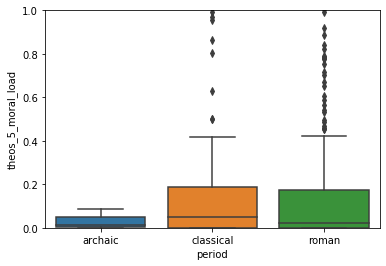

In [0]:
sns.boxplot(x="period", y="theos_5_moral_load", data=LG_results_theos.sort_values("period", ascending=True))
plt.ylim(0, 1)
plt.savefig(gdrive_root + "figures/boxplot_theos5.png", bbox_inches="tight")

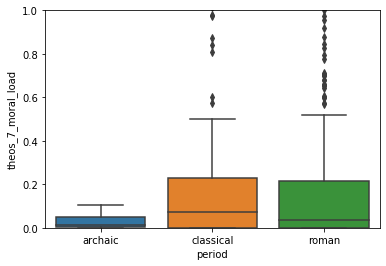

In [0]:
sns.boxplot(x="period", y="theos_7_moral_load", data=LG_data_results[LG_data_results["theos_count"]>0].sort_values("period", ascending=True))
plt.ylim(0, 1)
plt.savefig(gdrive_root + "figures/boxplot_theos7.png", bbox_inches="tight")

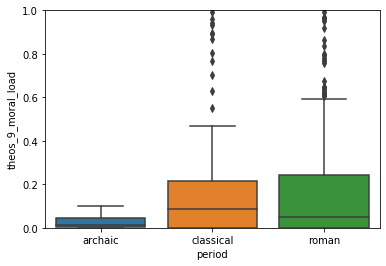

In [0]:
sns.boxplot(x="period", y="theos_9_moral_load", data=LG_data_results[LG_data_results["theos_count"]>0].sort_values("period", ascending=True))
plt.ylim(0, 1)
plt.savefig(gdrive_root + "figures/boxplot_theos9.png", bbox_inches="tight")

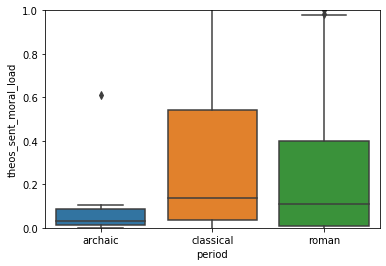

In [0]:
sns.boxplot(x="period", y="theos_sent_moral_load", data=LG_data_results[LG_data_results["theos_count"]>0].sort_values("period", ascending=True))
plt.ylim(0, 1)
plt.savefig(gdrive_root + "figures/boxplot_sent_theos.png", bbox_inches="tight")


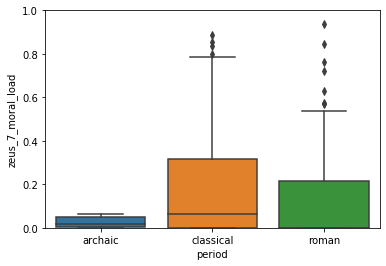

In [0]:
LG_data_results.sort_values("period", inplace=True)

sns.boxplot(x="period", y="zeus_7_moral_load", data=LG_data_results[LG_data_results["zeus_count"]>0])
plt.ylim(0, 1)
plt.savefig(gdrive_root + "figures/boxplot_zeus7.png", bbox_inches="tight")

In [0]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return (x,y)

def plot_ecdf(dataframe, data_column, selection_column, selection_value, color):
  data_values = np.array(dataframe[dataframe[selection_column]==selection_value][data_column])
  x, y = ecdf(data_values)
  return sns.scatterplot(x, y, color=color)

(0, 10)

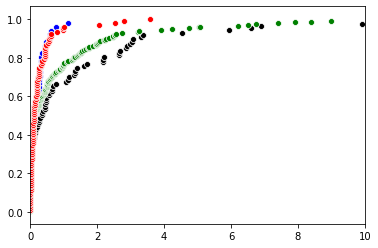

In [0]:
plot_ecdf(LG_data_results[LG_data_results["theos_count"]>0], "theos_7_moral_load", "century", -4.5, "blue")
plot_ecdf(LG_data_results[LG_data_results["theos_count"]>0], "theos_7_moral_load", "century", -3.5, "black")
plot_ecdf(LG_data_results[LG_data_results["theos_count"]>0][LG_data_results[LG_data_results["theos_count"]>0]["provenience"]=="pagan"], "theos_7_moral_load", "period", "roman", "green")
plot_ecdf(LG_data_results[LG_data_results["theos_count"]>0][LG_data_results[LG_data_results["theos_count"]>0]["provenience"]=="christian"], "theos_7_moral_load", "period", "roman", "red")
plt.xlim(0,10)

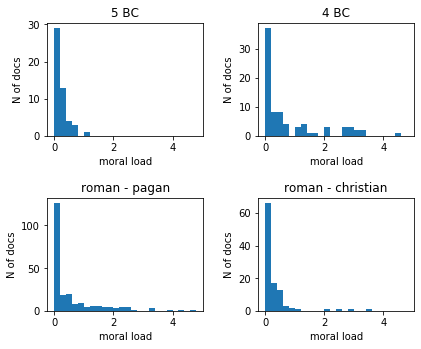

In [0]:
our_bins = list(np.array(range(25)) /5)
LG_results_theos = LG_data_results[LG_data_results["theos_count"]>0]

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(LG_results_theos[LG_results_theos["century"]==-4.5]["theos_7_moral_load"], bins=our_bins)
axs[0, 0].set_title('5 BC')
axs[0, 1].hist(LG_results_theos[LG_results_theos["century"]==-3.5]["theos_7_moral_load"], bins=our_bins, rwidth=1)
axs[0, 1].set_title('4 BC')
axs[1, 0].hist(LG_results_theos[(LG_results_theos["provenience"]=="pagan") & (LG_results_theos["period"]=="roman")]["theos_7_moral_load"], bins=our_bins, rwidth=1)
axs[1, 0].set_title('roman - pagan')
axs[1, 1].hist(LG_results_theos[LG_results_theos["provenience"]=="christian"]["theos_7_moral_load"], bins=our_bins, rwidth=1)
axs[1, 1].set_title('roman - christian')

for ax in axs.flat:
    ax.set(xlabel='moral load', ylabel='N of docs')



plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
plt.savefig(gdrive_root + "figures/hist_moral_counts.png", bbox_inches="tight")

(0, 1)

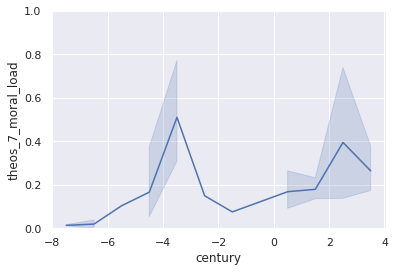

In [0]:
sns.set(color_codes=True)
sns.lineplot(x="century", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/regr_century.png")
plt.ylim(0, 1)

(0, 1)

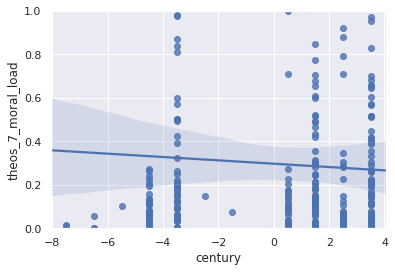

In [0]:
sns.set(color_codes=True)
sns.regplot(x="century", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/regr_century.png")
plt.ylim(0, 1)

(0, 1)

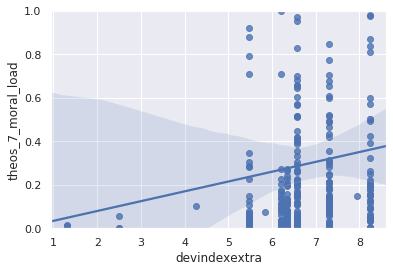

In [0]:
sns.set(color_codes=True)
sns.regplot(x="devindexextra", y="theos_7_moral_load", data=LG_results_theos)
#plt.savefig(gdrive_root + "figures/regr_devindex.png")
plt.ylim(0, 1)

In [0]:
def lin_model_line(dataframe, x_column, y_column, color):
  xd = np.array(dataframe[x_column])
  yd = np.array(dataframe[y_column])
  model_fit = ols(formula=y_column + " ~ " + x_column, data=dataframe).fit()
  a0 = model_fit.params["Intercept"]
  a1 = model_fit.params[x_column]
  y_model = a0 + xd*a1
  #plt.plot(xd, yd, "bo")
  #plt.axis(xmin=xmin, ymin=ymin)
  plt.xlabel(x_column)
  #plt.ylabel(y_column)
  #plt.savefig(gdrive_root + "figures/" + y_column + "_" + x_column + ".png")
  return plt.plot(xd, y_model, color)


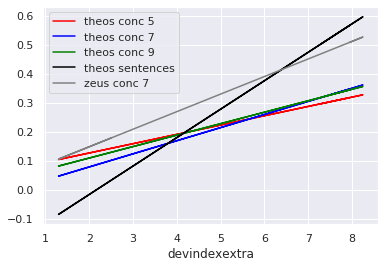

In [0]:
from matplotlib.lines import Line2D ### see https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
lines = []
for column, color in zip(["theos_5_moral_load", "theos_7_moral_load", "theos_9_moral_load", "theos_sent_moral_load"], ["red", "blue", "green", "black"]):
  lin_model_line(LG_results_theos, "devindexextra", column, color)
  lines.append(Line2D([0], [0], color=color))
### add zeus individually
lin_model_line(LG_data_results[LG_data_results["zeus_count"]>0], "devindexextra", "zeus_7_moral_load", "grey")
lines.append(Line2D([0], [0], color="grey"))
plt.legend(lines, ['theos conc 5', 'theos conc 7', 'theos conc 9', 'theos sentences', "zeus conc 7"])
#plt.savefig(gdrive_root + "figures/regr_lines_devindex.png")
plt.show()


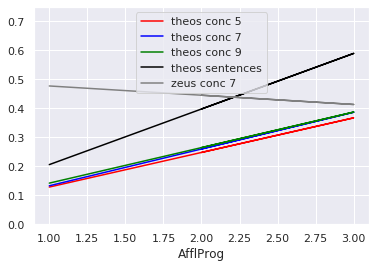

In [0]:
lines = []
for column, color in zip(["theos_5_moral_load", "theos_7_moral_load", "theos_9_moral_load", "theos_sent_moral_load"], ["red", "blue", "green", "black"]):
  lin_model_line(LG_results_theos, "AfflProg", column, color)
  lines.append(Line2D([0], [0], color=color))
plt.legend(lines, ['theos conc 5', 'theos conc 7', 'theos conc 9', 'theos sentences'])
### add zeus individually
lin_model_line(LG_data_results[LG_data_results["zeus_count"]>0], "AfflProg", "zeus_7_moral_load", "grey")
lines.append(Line2D([0], [0], color="grey"))
plt.legend(lines, ['theos conc 5', 'theos conc 7', 'theos conc 9', 'theos sentences', "zeus conc 7"])
plt.ylim(0,0.75)
plt.savefig(gdrive_root + "figures/regr_lines_afflprog.png")
plt.show()

(0, 1)

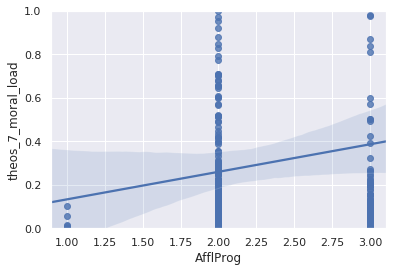

In [0]:
sns.set(color_codes=True)
sns.regplot(x="AfflProg", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/regr_afflprog.png")
plt.ylim(0, 1)

(-1, 1)

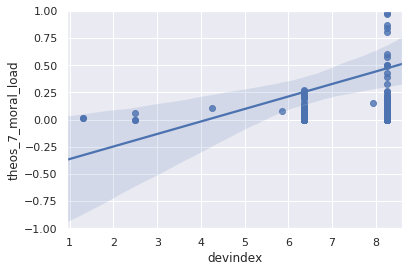

In [0]:
sns.set(color_codes=True)
sns.regplot(x="devindex", y="theos_7_moral_load", data=LG_results_theos[LG_results_theos["century"]<0])
plt.savefig(gdrive_root + "figures/regr_devindex.png")
plt.ylim(-1, 1)

(0, 1)

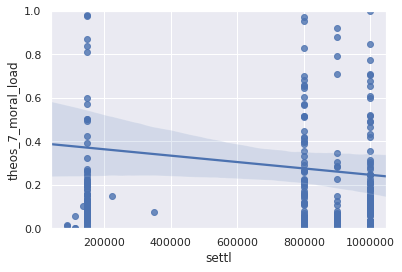

In [0]:
sns.set(color_codes=True)
sns.regplot(x="settl", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/regr_settl.png")
plt.ylim(0, 1)

(0, 1)

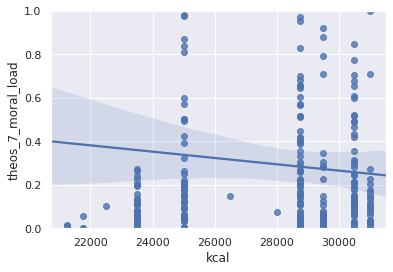

In [0]:
sns.set(color_codes=True)
sns.regplot(x="kcal", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/regr_kcal.png")
plt.ylim(0, 1)

(0, 1)

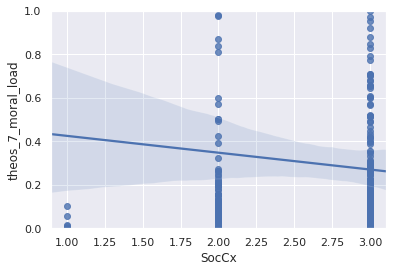

In [0]:
sns.set(color_codes=True)
sns.regplot(x="SocCx", y="theos_7_moral_load", data=LG_results_theos)
plt.savefig(gdrive_root + "figures/SocCx.png")
plt.ylim(0, 1)

# ARCHIVE - OLD FUNCTIONS


In [0]:
concordances_merged = []
for row in concordance:
    concordances_merged.extend(row[0])

In [0]:
### export for manual coding of indicators
concordance_coding = []
for term_tuple in nltk.FreqDist(concordances_merged).most_common(200):
    concordance_coding.append([term_tuple[0], translation_only(term_tuple[0]), term_tuple[1], ""])
concordance_coding_df = pd.DataFrame(concordance_coding, columns=["term", "translation", "frequency", "indicator"])

In [0]:
set_with_dataframe(sh.add_worksheet(title="coding_morality_power", rows=1, cols=1), concordance_coding_df)

In [0]:
###upload back the manually coded data
concordance_coding_df_coded = get_as_dataframe(sh.worksheet("coding_morality_power"))
morality = []
power = []
power_and_morality = []
for index, row in concordance_coding_df_coded.iterrows():
    if row["indicator"]=="morality":
        morality.append(row["term"])
        power_and_morality.append(row["term"])
    if row["indicator"]=="power":
        power.append(row["term"])
        power_and_morality.append(row["term"])

In [0]:
morality

['ἀγαθός', 'δίκαιος', 'ἀλήθεια', 'ἀρετή', 'δίκη', 'ἀληθής']

In [0]:
### manually arranged alphabetically:
morality = ['ἀγαθός', 'ἀλήθεια', 'ἀληθής', 'ἀρετή', 'δίκαιος', 'δίκη']

In [0]:
", ".join([translator_special(term) for term in morality])

'\\greektext ἀγαθός \\latintext (good), \\greektext ἀλήθεια \\latintext (truth), \\greektext ἀληθής \\latintext (unconcealed, true), \\greektext ἀρετή \\latintext (virtue, moral excellence, perfection), \\greektext δίκαιος \\latintext (just, righteous, impartial), \\greektext δίκη \\latintext (justice, judicial hearing, punishment)'

In [0]:
power

['μόνος', 'μέγας', 'δύναμις', 'εἷς', 'δυνατός']

In [0]:
### manually arranged alphabetically:
power = ['δύναμις', 'δυνατός', 'εἷς', 'μέγας', 'μόνος']

In [0]:
", ".join([translator_special(term) for term in power])

'\\greektext δύναμις \\latintext (might, power, marvelous works), \\greektext δυνατός \\latintext (powerful, able, possible), \\greektext εἷς \\latintext (one), \\greektext μέγας \\latintext (large, great), \\greektext μόνος \\latintext (only, solitary, desolate)'

In [0]:
power_and_morality = morality + power

In [0]:
", ".join([translator_short(term) for term in power_and_morality])

'ἀγαθός (good), ἀλήθεια (truth), ἀληθής (unconcealed, true), ἀρετή (virtue, moral excellence), δίκαιος (just, righteous), δίκη (justice, judicial hearing), δύναμις (might, power), δυνατός (powerful, able), εἷς (one), μέγας (large, great), μόνος (only, solitary)'

In [0]:
### to generate indicators of violence
archaic_words = []
for row in concordance:
    if row[2] < -5:
        archaic_words.extend(row[0])
archaic_200 = pd.DataFrame([[term_tuple[0], translation_only(term_tuple[0]), term_tuple[1]] for term_tuple in nltk.FreqDist(archaic_words).most_common(200)], columns=["term", "translation", "freq"])

In [0]:
### for coding heroism
set_with_dataframe(sh.add_worksheet("archaic_200", rows=1,cols=4), archaic_200)

In [0]:
###uploading back after manual coding
archaic_200_coded = get_as_dataframe(sh.worksheet("archaic_200"))
heroism = archaic_200_coded[archaic_200_coded["heroism"]=="heroism"]["term"].tolist()
heroism

['θυμός', 'δεινός', 'πόλεμος', 'χαλεπός', 'βία', 'μάχη']

In [0]:
### ordered alphabetically
heroism = ['βία', 'δεινός', 'θυμός', 'μάχη','πόλεμος', 'χαλεπός']
### printed with translation
", ".join([translator(term) for term in heroism])

'βία (force, violence), δεινός (fearful, terrible, dread, dire), θυμός (an outburst of passion, wrath), μάχη (strife, contention, quarrel), πόλεμος (a war, battle, strife), χαλεπός (hard, harsh, fierce)'

In [0]:
", ".join([translator_special(term) for term in heroism])

'\\greektext βία \\latintext (force, violence), \\greektext δεινός \\latintext (fearful, terrible, dread, dire), \\greektext θυμός \\latintext (an outburst of passion, wrath), \\greektext μάχη \\latintext (strife, contention, quarrel), \\greektext πόλεμος \\latintext (a war, battle, strife), \\greektext χαλεπός \\latintext (hard, harsh, fierce)'

In [0]:
all_indicators = []
for element in morality:
    all_indicators.append([element,translation_only(element),"morality"])
for element in power:
    all_indicators.append([element,translation_only(element),"power"])
for element in heroism:
    all_indicators.append([element,translation_only(element),"heroism"])
sh.del_worksheet(sh.worksheet("all_indicators"))
set_with_dataframe(sh.add_worksheet("all_indicators", rows=1,cols=1), pd.DataFrame(all_indicators, columns=["term", "translation", "category"]))

In [0]:
all_indicators = pd.DataFrame(all_indicators, columns=["term", "translation", "category"])

In [0]:
def indicators_counting(indicators, row):
    terms_count = 0
    if row["number_of_docs"] > 1:
        merged_lemmata = " ".join(row["lemmata"]).split()
    else:
        merged_lemmata = row["lemmata"][0].split()
    for term in indicators:
        terms_count = terms_count + merged_lemmata.count(term)
    return terms_count

authors_lemmata_df['morality_count'] = authors_lemmata_df.apply(lambda row: indicators_counting(morality, row), axis=1)
authors_lemmata_df['power_count'] = authors_lemmata_df.apply(lambda row: indicators_counting(power, row), axis=1)
authors_lemmata_df['heroism_count'] = authors_lemmata_df.apply(lambda row: indicators_counting(heroism, row), axis=1)

In [0]:
### to look at the data on the by-century-basis

peak_data = authors_lemmata_df.groupby("peak").sum()
peak_data["morality_rel_freq"] = peak_data.apply(lambda row: (row["morality_count"] / row["word_count"]) * 100, axis=1)
peak_data["power_rel_freq"] = peak_data.apply(lambda row: (row["power_count"] / row["word_count"]) * 100, axis=1)
peak_data["heroism_rel_freq"] = peak_data.apply(lambda row: (row["heroism_count"] / row["word_count"]) * 100, axis=1)
peak_data["theos_rel_freq"] = peak_data.apply(lambda row: (row["theos_count"] / row["word_count"]) * 100, axis=1)
peak_data["zeus_rel_freq"] = peak_data.apply(lambda row: (row["zeus_count"] / row["word_count"]) * 100, axis=1)

peak_data.reset_index(inplace=True)
peak_data

,peak,number_of_docs,word_count,theos_count,zeus_count,theos_rel_freq,zeus_rel_freq,morality_count,power_count,heroism_count,morality_rel_freq,power_rel_freq,heroism_rel_freq
0,-7.5,2,68514,741,703,1.081531,1.026068,210,767,1420,0.306507,1.119479,2.072569
1,-6.5,3,3974,87,76,2.189230,1.912431,22,70,84,0.553598,1.761449,2.113739
2,-5.5,1,10593,58,88,0.547531,0.830737,88,185,61,0.830737,1.746436,0.575852
3,-4.5,68,200850,1668,1185,0.830471,0.589993,2101,3412,1954,1.046054,1.698780,0.972865
4,-3.5,152,467933,1430,649,0.305599,0.138695,6720,11657,2404,1.436103,2.491169,0.513749
5,-1.5,1,78183,106,29,0.135579,0.037092,377,2295,1071,0.482202,2.935421,1.369863
6,0.5,26,93537,1756,236,1.877332,0.252307,1162,2447,623,1.242289,2.616077,0.666047
7,1.5,108,448931,4025,1295,0.896574,0.288463,3472,9372,3748,0.773393,2.087626,0.834872
8,2.5,130,1245946,6094,898,0.489106,0.072074,10470,36507,2764,0.840325,2.930063,0.221839
9,3.5,21,157109,1334,181,0.849092,0.115207,2818,3696,1673,1.793659,2.352507,1.064866


In [0]:
### insert a dataframe into the spreadsheet
sh.del_worksheet(sh.worksheet("indicators_by_century"))
set_with_dataframe(sh.add_worksheet(title="indicators_by_century", rows=1, cols=1), peak_data)

In [0]:
### is there an increasing trend over time?
x = peak_data["peak"]
y = peak_data["morality_rel_freq"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

r=0.53931, p=0.10766


In [0]:
###look at the diachronical distribution of individual indicator terms

individual_indicator_terms = []
for author in authors_lemmata_df["author"].tolist():
    peak = authors_lemmata_df[authors_lemmata_df["author"]==author]["peak"].tolist()[0]
    author_values = [author, peak]
    if authors_lemmata_df[authors_lemmata_df["author"]==author]["number_of_docs"].tolist()[0] > 1:
        merged_lemmata = " ".join(authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0]).split()
    else: 
        merged_lemmata = authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0][0].split()
    for term in [element[0] for element in all_indicators]:
        author_values.append((merged_lemmata.count(term) / peak_data[peak_data["peak"]==peak]["word_count"].tolist()[0]) * 100)
    individual_indicator_terms.append(author_values)
individual_indicator_terms_df = pd.DataFrame(individual_indicator_terms).groupby(1).sum()
individual_indicator_terms_df.columns = [element[0] for element in all_indicators]
individual_indicator_terms_df.reset_index(inplace=True)
individual_indicator_terms_df.sort_values(9, axis=1, ascending=False, inplace=True)
individual_indicator_terms_df

,1,μέγας,μόνος,δίκαιος,ἀγαθός,δίκη,δεινός,εἷς,πόλεμος,ἀρετή,δύναμις,μάχη,χαλεπός,ἀληθής,θυμός,ἀλήθεια,δυνατός,βία
0,-7.5,0.957469,0.051084,0.021893,0.180985,0.023353,0.141577,0.094871,0.407216,0.054004,0.016055,0.195580,0.072978,0.013136,1.104884,0.013136,0.000000,0.150334
1,-6.5,1.660795,0.025164,0.125818,0.150981,0.201309,0.679416,0.050327,0.201309,0.000000,0.025164,0.125818,0.050327,0.050327,0.578762,0.025164,0.000000,0.478108
2,-5.5,0.632493,0.632493,0.169924,0.264325,0.094402,0.103842,0.264325,0.151043,0.066081,0.084962,0.169924,0.103842,0.141603,0.009440,0.094402,0.132163,0.037761
3,-4.5,0.813542,0.354991,0.197660,0.267364,0.256410,0.217077,0.315658,0.342046,0.177247,0.134429,0.210107,0.047797,0.100075,0.057257,0.047299,0.080159,0.098581
4,-3.5,0.953769,0.493447,0.232512,0.564824,0.067531,0.134421,0.508192,0.132711,0.160707,0.367574,0.052999,0.132925,0.345135,0.012395,0.065394,0.168186,0.048298
5,-1.5,0.871033,0.539759,0.136858,0.094650,0.028139,0.126626,0.356855,0.795569,0.071627,0.964404,0.301856,0.010232,0.040930,0.047325,0.109998,0.203369,0.088254
6,0.5,0.888418,0.738745,0.225579,0.440467,0.082320,0.181746,0.540962,0.171055,0.116531,0.286518,0.051317,0.199921,0.182815,0.034211,0.194575,0.161433,0.027796
7,1.5,0.789654,0.497627,0.104248,0.281780,0.129419,0.081304,0.432138,0.340364,0.088432,0.267970,0.288686,0.048783,0.105361,0.037645,0.064152,0.100238,0.038090
8,2.5,0.697542,0.820581,0.081304,0.315262,0.029857,0.037080,0.567119,0.038445,0.085397,0.720978,0.027208,0.054577,0.238373,0.044304,0.090132,0.123842,0.020226
9,3.5,1.057228,0.618679,0.481831,0.448097,0.397176,0.373626,0.361532,0.305520,0.269240,0.233596,0.150214,0.121572,0.108842,0.090383,0.088474,0.081472,0.023551


In [0]:
set_with_dataframe(sh.add_worksheet("individual_indicators_by_century", rows=1, cols=1), individual_indicator_terms_df)

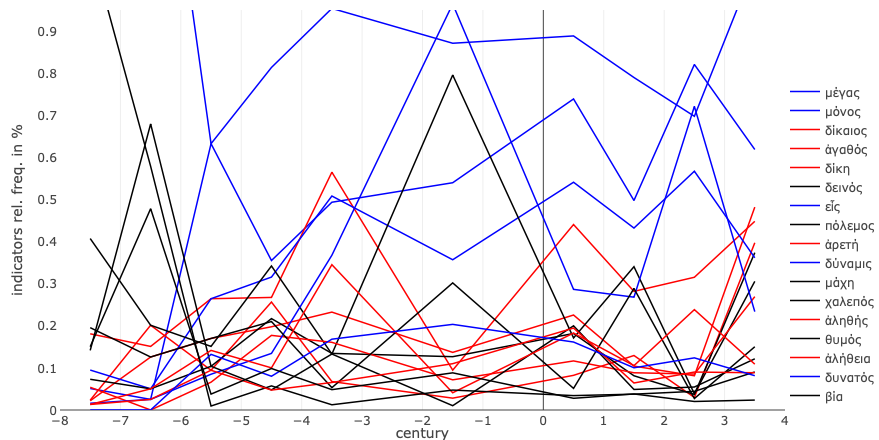

In [0]:
traces_data = []
annotations = []
value = 0
for term in individual_indicator_terms_df.columns.tolist()[1:]:
    if term in morality:
        color="red"
    if term in power:
        color="blue"
    if term in heroism:
        color ="black"
    traces_data.append(
        go.Scatter(
            x=individual_indicator_terms_df[1].tolist(),
            y=individual_indicator_terms_df[term].tolist(),
            mode="lines",
            #yaxis="y5",
            connectgaps=True,
            line=dict(
                color=color,            
                width=1.5,
                #dash="dot"
                ),
            name=term))
    value = value + 1
    if value % 3 == 0:
        x_value = -3.5
        y_value = individual_indicator_terms_df[individual_indicator_terms_df[1]==-3.5][term].tolist()[0]
    else:
        x_value =0.5
        y_value = individual_indicator_terms_df[individual_indicator_terms_df[1]==0.5][term].tolist()[0]
    annotations.append(
        dict(x=x_value, y=y_value, xref="x", yref="y", text=term, ax=0,ay=0,font=dict(size=10, color=color))
        )
layout = go.Layout(
    #showlegend=False,
    autosize=False,
    width=640,
    height=440,
    xaxis=dict(showgrid=True, dtick=1, title="century", range=[-8,4]),
    yaxis=dict(showgrid=False,title="indicators rel. freq. in %", range=[0,0.95]),
    margin=dict(
        l=60,r=0,t=10,b=30,pad=2),
    legend=dict(
        x=1, y=0)
    
    #annotations=annotations
    )
fig= go.Figure(data=traces_data, layout=layout)

###pio.write_image(fig, "../images/prox_power_morality_authors_mean.eps", scale=1)
iplot(fig, filename="individual_indicator_terms.html")

In [0]:
pio.write_image(fig, '../figures/individual_indicator_terms.eps', scale=1)

In [0]:
def term_rel_counter(author, term):
    if authors_lemmata_df[authors_lemmata_df["author"]==author]["number_of_docs"].tolist()[0] > 1:
        merged_lemmata = " ".join(authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0]).split()
    else: 
        merged_lemmata = authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0][0].split()
    return merged_lemmata.count(term) / len(merged_lemmata)

In [0]:
authors = authors_lemmata_df["author"].tolist()
authors_ind_rel_freq = []
for author in authors:
    terms_rel_freq = []
    for term in all_indicators["term"].tolist():
        terms_rel_freq.append(term_rel_counter(author, term))
    authors_ind_rel_freq.append([author] + terms_rel_freq)
authors_ind_rel_freq_df = pd.DataFrame(authors_ind_rel_freq)
authors_ind_rel_freq_df.columns = ["author"] + all_indicators["term"].tolist()
#authors_ind_rel_freq_df.set_index("author", inplace=True)
authors_ind_rel_freq_df.head(5)

,author,ἀγαθός,ἀλήθεια,ἀληθής,ἀρετή,δίκαιος,δίκη,δύναμις,δυνατός,εἷς,μέγας,μόνος,βία,δεινός,θυμός,μάχη,πόλεμος,χαλεπός
0,Galen,0.001179,0.000470,0.001176,0.000288,0.000467,0.000160,0.009013,0.001146,0.004879,0.008027,0.009876,0.000152,0.000264,0.000391,0.000138,0.000053,0.000663
1,Alexander of Aphrodisias,0.007931,0.000796,0.008713,0.002048,0.001424,0.000034,0.007226,0.002215,0.009682,0.005994,0.006555,0.000249,0.000048,0.000019,0.000077,0.000096,0.000614
2,Athenaeus,0.002204,0.000238,0.000147,0.000686,0.000406,0.000539,0.000819,0.000189,0.003786,0.006858,0.005017,0.000238,0.000763,0.000602,0.000462,0.001001,0.000294
3,Aristotle,0.005205,0.000327,0.005540,0.001738,0.001418,0.000145,0.003926,0.001985,0.006819,0.006180,0.005801,0.000349,0.000196,0.000124,0.000087,0.000305,0.000800
4,Libanius,0.004125,0.000579,0.000946,0.002128,0.005722,0.004728,0.001981,0.000628,0.003546,0.011926,0.005926,0.000220,0.004630,0.000929,0.000897,0.002445,0.001427


In [0]:
sh.del_worksheet(sh.worksheet("individual_indiciators_by_authors"))
set_with_dataframe(sh.add_worksheet("individual_indiciators_by_authors", rows=1, cols=1), authors_ind_rel_freq_df)

# Mutual Information

In [0]:
### control terms, i.e. 200 overall most common terms in the the concordances
most_common_200 = concordance_coding_df_coded["term"].tolist()

In [0]:
### to get a simple overview of periods
dataset_periods = [authors_lemmata_df[authors_lemmata_df["peak"] < -4], authors_lemmata_df[(authors_lemmata_df["peak"] > -4) & (authors_lemmata_df["peak"] < 0)], authors_lemmata_df[authors_lemmata_df["peak"] > 0]]
for dataset in dataset_periods:
    period_lemmata = dataset["lemmata"].tolist()
    period_lemmata_list = []
    for element in  [", ".join(author_lemmata).split() for author_lemmata in period_lemmata]:
        period_lemmata_list.extend(element)
    print(len(period_lemmata_list), period_lemmata_list.count("θεός") / len(period_lemmata_list), len(nltk.FreqDist(period_lemmata_list)))

In [0]:
### an overview of the texts as a whole
lemmata_list = []
for element in  [", ".join(author_lemmata).split() for author_lemmata in authors_lemmata_df["lemmata"].tolist()]:
    lemmata_list.extend(element)
theos_overall_rel_freq = lemmata_list.count("θεός") / len(lemmata_list)
print(len(lemmata_list), lemmata_list.count("θεός"),theos_overall_rel_freq, len(nltk.FreqDist(lemmata_list)))

In [0]:
periods_means= []
dataset_periods = [authors_lemmata_df[authors_lemmata_df["peak"] < -4], authors_lemmata_df[(authors_lemmata_df["peak"] > -4) & (authors_lemmata_df["peak"] < 0)], authors_lemmata_df[authors_lemmata_df["peak"] > 0]]
for dataset in dataset_periods:
    period_lemmata = dataset["lemmata"].tolist()
    period_lemmata_list = []
    for element in  [", ".join(author_lemmata).split() for author_lemmata in period_lemmata]:
        period_lemmata_list.extend(element)
    concordance = author_concordance_generator(dataset, "θεός")
    concordances_merged = []
    for concordance_row in concordance:
        concordance_terms = concordance_row[0]
        concordance_terms.remove("θεός")
        concordances_merged.extend(concordance_terms)
    indicators_conc_counts = []
    N = len(period_lemmata_list) ### number of words in the subcorpus
    Px = theos_overall_rel_freq ### rel.freq. of the key term
    for term in most_common_200:
        if (term not in power_and_morality) & (term in concordances_merged):
            Pxy = concordances_merged.count(term) / len(concordances_merged)
            Py = period_lemmata_list.count(term) / N
            MI = (Pxy / (Px * Py))
            if MI != 0:
                MI = math.log2(MI)
            indicators_conc_counts.append(MI)    
    periods_means.append(np.mean(indicators_conc_counts))
[round(number, 5) for number in periods_means]

In [0]:
### mutual information 

data = []
dataset_periods = [authors_lemmata_df[authors_lemmata_df["peak"] < -4], authors_lemmata_df[(authors_lemmata_df["peak"] > -4) & (authors_lemmata_df["peak"] < 0)], authors_lemmata_df[authors_lemmata_df["peak"] > 0]]
for dataset, mean in zip(dataset_periods, periods_means):
    period_lemmata = dataset["lemmata"].tolist()
    period_lemmata_list = []
    for element in  [", ".join(author_lemmata).split() for author_lemmata in period_lemmata]:
        period_lemmata_list.extend(element)
    concordance = author_concordance_generator(dataset, "θεός")
    concordances_merged = []
    for concordance_row in concordance:
        concordance_terms = concordance_row[0]
        concordance_terms.remove("θεός")
        concordances_merged.extend(concordance_terms)
    indicators_conc_counts = []
    N = len(period_lemmata_list)
    Px = theos_overall_rel_freq
    for indicator in power_and_morality:
        Pxy = concordances_merged.count(indicator) / len(concordances_merged)
        Py = period_lemmata_list.count(indicator) / N
        MI = (Pxy / (Px * Py))
        if MI != 0:
            MI = math.log2(MI)
        indicators_conc_counts.append(MI)
    data.append(indicators_conc_counts)
data_MI_df = pd.DataFrame(data)
data_MI_df.columns = power_and_morality
data_MI_df

In [0]:
### morality mean
[round(data_MI_df.loc[0][:5].mean(), 5), round(data_MI_df.loc[1][:5].mean(), 5), round(data_MI_df.loc[2][:5].mean(), 5)]

In [0]:
### power mean
[round(data_MI_df.loc[0][6:].mean(), 5), round(data_MI_df.loc[1][6:].mean(), 5), round(data_MI_df.loc[2][6:].mean(), 5)]

In [0]:
trace1 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_MI_df.loc[0],
    name='early',
    marker=dict(color="green")
)
trace2 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_MI_df.loc[1],
    name='middle',
    marker=dict(color="blue")
)

trace3 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_MI_df.loc[2],
    name='later',
    marker=dict(color="orange")
)


data = [trace1, trace2,trace3]
layout = go.Layout(
    #showlegend=False,
    title="θεός",
    barmode='group',
    autosize=False,
    width=640,
    height=320,
    yaxis=dict(title="indicators MI"),
    xaxis=dict(tickangle=55),
    margin=dict(
        l=40,r=100,t=30,b=180,pad=2),
    legend=dict(
        x=1, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [0]:
pio.write_image(fig, '../figures/results_MI_theos.eps', scale=1)

In [0]:
### the same with Zeus

periods_means= []
dataset_periods = [authors_lemmata_df[authors_lemmata_df["peak"] < -4], authors_lemmata_df[(authors_lemmata_df["peak"] > -4) & (authors_lemmata_df["peak"] < 0)], authors_lemmata_df[authors_lemmata_df["peak"] > 0]]
for dataset in dataset_periods:
    period_lemmata = dataset["lemmata"].tolist()
    period_lemmata_list = []
    for element in  [", ".join(author_lemmata).split() for author_lemmata in period_lemmata]:
        period_lemmata_list.extend(element)
    concordance = author_concordance_generator(dataset, "ζεύς")
    concordances_merged = []
    for concordance_row in concordance:
        concordance_terms = concordance_row[0]
        concordance_terms.remove("ζεύς")
        concordances_merged.extend(concordance_terms)
    indicators_conc_counts = []
    N = len(period_lemmata_list) ### number of words in the subcorpus
    Px = theos_overall_rel_freq
    for term in most_common_200:
        if (term not in power_and_morality) & (term in concordances_merged):
            Pxy = concordances_merged.count(term) / len(concordances_merged)
            Py = period_lemmata_list.count(term) / N
            MI = (Pxy / (Px * Py))
            if MI != 0:
                MI = math.log2(MI)
            indicators_conc_counts.append(MI)    
    periods_means.append(np.mean(indicators_conc_counts))
periods_means

In [0]:
### mutual information weighted by average MI in of the 200 most frequent terms in the concordances, except the indicator terms

data = []
dataset_periods = [authors_lemmata_df[authors_lemmata_df["peak"] < -4], authors_lemmata_df[(authors_lemmata_df["peak"] > -4) & (authors_lemmata_df["peak"] < 0)], authors_lemmata_df[authors_lemmata_df["peak"] > 0]]
for dataset, mean in zip(dataset_periods, periods_means):
    period_lemmata = dataset["lemmata"].tolist()
    period_lemmata_list = []
    for element in  [", ".join(author_lemmata).split() for author_lemmata in period_lemmata]:
        period_lemmata_list.extend(element)
    concordance = author_concordance_generator(dataset, "ζεύς")
    concordances_merged = []
    for concordance_row in concordance:
        concordance_terms = concordance_row[0]
        concordance_terms.remove("ζεύς")
        concordances_merged.extend(concordance_terms)
    indicators_conc_counts = []
    N = len(period_lemmata_list)
    Px = theos_overall_rel_freq
    for indicator in power_and_morality:
        Pxy = concordances_merged.count(indicator) / len(concordances_merged)
        Py = period_lemmata_list.count(indicator) / N
        MI = (Pxy / (Px * Py))
        if MI != 0:
            MI = math.log2(MI)
        indicators_conc_counts.append(MI)
    data.append(indicators_conc_counts)
data_df = pd.DataFrame(data)
data_df.columns = power_and_morality
data_df

In [0]:
### morality mean
[round(data_df.loc[0][:5].mean(), 5), round(data_df.loc[1][:5].mean(), 5), round(data_df.loc[2][:5].mean(), 5)]

In [0]:
### power mean
[round(data_df.loc[0][6:].mean(), 5), round(data_df.loc[1][6:].mean(), 5), round(data_df.loc[2][6:].mean(), 5)]

In [0]:
trace1 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_df.loc[0],
    name='early',
    marker=dict(color="green")
)
trace2 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_df.loc[1],
    name='middle',
    marker=dict(color="blue")
)

trace3 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=data_df.loc[2],
    name='later',
    marker=dict(color="orange")
)


data = [trace1, trace2,trace3]
layout = go.Layout(
    #showlegend=False,
    title="ζεύς",
    barmode='group',
    autosize=False,
    width=640,
    height=320,
    yaxis=dict(title="indicators MI"),
    xaxis=dict(tickangle=55),
    margin=dict(
        l=40,r=100,t=30,b=180,pad=2),
    legend=dict(
        x=1, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [0]:
pio.write_image(fig, '../figures/results_MI_zeus.eps', scale=1)

# Our Own Weighting Method

In [0]:
### to check whether there are indicators of power and morality in the concordance rows
def indicators_counter(concordance_list):
    concordance_rows_indicators = []
    for row in concordance_list:
        theos_morality_total = 0
        theos_power_total = 0
        theos_power_and_morality = 0
        for term in row:
            if term in morality:
                theos_morality_total = theos_morality_total + 1
            if term in power:
                theos_power_total = theos_power_total + 1
            if term in power_and_morality:
                theos_power_and_morality = theos_power_and_morality + 1
        concordance_rows_indicators.append([theos_morality_total, theos_power_total, theos_power_and_morality])
    concordance_rows_indicators_df = pd.DataFrame(concordance_rows_indicators)
    concordance_rows_indicators_df.columns = ["morality", "power", "power_and_morality"]
    return concordance_rows_indicators_df

def term_rel_counter(author, term):
    if authors_lemmata_df[authors_lemmata_df["author"]==author]["number_of_docs"].tolist()[0] > 1:
        merged_lemmata = " ".join(authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0]).split()
    else: 
        merged_lemmata = authors_lemmata_df[authors_lemmata_df["author"]==author]["lemmata"].tolist()[0][0].split()
    return merged_lemmata.count(term) / len(merged_lemmata)
    
def indicators_counter_data(concordance_data):
    concordance_rows_indicators = []
    for row in concordance_data:
        theos_morality_total = 0
        theos_power_total = 0
        theos_heroism = 0
        for term in row[0]:
            if term in morality:
                theos_morality_total = theos_morality_total + 1
            if term in power:
                theos_power_total = theos_power_total + 1
            if term in heroism:
                theos_heroism = theos_power_and_morality + 1
                theos_power_and_morality_prop = theos_power_and_morality_prop + (1 / term_rel_counter(row[1], term))
        concordance_rows_indicators.append([row[1], row[2], row[3], row[0], theos_morality_total, theos_power_total, theos_power_and_morality, theos_power_and_morality_prop])
    concordance_rows_indicators_df = pd.DataFrame(concordance_rows_indicators)
    concordance_rows_indicators_df.columns = ["author", "peak", "provenience", "concordance", "morality", "power", "power_and_morality", "power_and_morality_prop"]
    return concordance_rows_indicators_df


In [0]:
authors = authors_lemmata_df["author"].tolist()
authors_ind_rel_freq = []
for author in authors:
    terms_rel_freq = []
    for term in power_and_morality:
        terms_rel_freq.append(term_rel_counter(author, term))
    authors_ind_rel_freq.append([author] + terms_rel_freq)

In [0]:
authors_ind_rel_freq_df = pd.DataFrame(authors_ind_rel_freq)
authors_ind_rel_freq_df.columns = ["author"] + power_and_morality
authors_ind_rel_freq_df.set_index("author", inplace=True)
authors_ind_rel_freq_df.head(5)

In [0]:
def individual_indicators_counter_data(concordance_data):
    concordance_rows_indicators = []
    for row in concordance_data:
        individual_terms_values = []
        for term in power_and_morality:
            term_rel_freq = authors_ind_rel_freq_df.loc[row[1]][term]
            if term_rel_freq == 0:
                individual_terms_values.append(0)
            else:
                if row[0].count(term) == 0: 
                    individual_terms_values.append(0)
                else:
                    individual_terms_values.append(math.log2(row[0].count(term) / term_rel_freq))
                
        morality = sum(individual_terms_values[:6])
        power = sum(individual_terms_values[6:])
        morality_and_power = sum(individual_terms_values)
        concordance_rows_indicators.append([row[1], row[2], row[3], row[0], morality, power, morality_and_power]  + individual_terms_values)
    concordance_rows_indicators_df = pd.DataFrame(concordance_rows_indicators)
    concordance_rows_indicators_df.columns = ["author", "peak", "provenience", "concordance", "morality", "power", "power_and_morality"] + power_and_morality
    return concordance_rows_indicators_df

# Theos application - extended

In [0]:
### generate a list of lists
### in the inner lists, there is a concordance row, author, provenience and peak
concordance_theos = author_concordance_generator(authors_lemmata_df, "θεός")
### make a dataferame from the concordance and count occurrances of power and morality indicators in each concordance row

In [0]:
len(concordance_theos)

In [0]:
individual_indicatores_data_df = individual_indicators_counter_data(concordance_theos)

In [0]:
grouped_by_peak_weighted = individual_indicatores_data_df.groupby("peak").mean()
grouped_by_peak_weighted

In [0]:
grouped_by_peak_weighted.drop(["morality", "power", "power_and_morality"], axis=1, inplace=True)
grouped_by_peak_weighted.reset_index(inplace=True)
grouped_by_peak_weighted.sort_values(9, axis=1, ascending=False, inplace=True)
grouped_by_peak_weighted

In [0]:
traces_data = []
annotations = []
value = 0
for term in grouped_by_peak_weighted.columns.tolist()[1:]:
    color="rgb"+ str(tuple(np.random.choice(range(256), size=3))) + ""
    traces_data.append(
        go.Scatter(
            x=grouped_by_peak_weighted["peak"].tolist(),
            y=grouped_by_peak_weighted[term].tolist(),
            mode="lines",
            #yaxis="y5",
            connectgaps=True,
            line=dict(
                color=color,            
                width=1.5,
                #dash="dot"
                ),
            name=term))
    value = value + 1
    if value % 3 == 0:
        x_value = -3.5
        y_value = grouped_by_peak_weighted[grouped_by_peak_weighted["peak"]==-3.5][term].tolist()[0]
    else:
        x_value =0.5
        y_value = grouped_by_peak_weighted[grouped_by_peak_weighted["peak"]==0.5][term].tolist()[0]
    annotations.append(
        dict(x=x_value, y=y_value, xref="x", yref="y", text=term, ax=0,ay=0,font=dict(size=10, color=color))
        )
layout = go.Layout(
    #showlegend=False,
    autosize=False,
    width=640,
    height=320,
    xaxis=dict(showgrid=True, dtick=1, title="century", range=[-8,4]),
    yaxis=dict(showgrid=False,title="individual MI", range=[0,0.5]),
    margin=dict(
        l=60,r=0,t=10,b=30,pad=2),
    legend=dict(
        x=1, y=0)
    
    #annotations=annotations
    )
fig= go.Figure(data=traces_data, layout=layout)

###pio.write_image(fig, "../images/prox_power_morality_authors_mean.eps", scale=1)
iplot(fig, filename="individual_indicator_terms.html")

In [0]:
pio.write_image(fig, '../figures/diachronical_terms_in_conc_weighted.eps', scale=1)

In [0]:
indicatores_data_df = indicators_counter_data(concordance_theos)

In [0]:
indicatores_data_df.head(5)

In [0]:
### is there a relationship between the mean indicators relative count in the concordance rows and the theos norm count?
authors_indicators = indicatores_data_df.groupby("author").mean().reset_index()  ###inplace=True)
authors_merged = pd.merge(authors_indicators, authors_lemmata_df, on="author")
authors_merged = authors_merged.drop(['morality', 'power', 'lemmata', 'number_of_docs', 'theos_count', 'zeus_count', 'peak_y'], axis=1)
authors_merged["indicators_rel_freq"] = authors_merged.apply(lambda row: (row["morality_count"] + row["power_count"]) / row["word_count"], axis=1)
authors_merged.sort_values("peak_x", ascending=True).head(10)

# Some correlations...

In [0]:
### is there a relationship between frequency of usage of the indicators terms
### and their usage in the concordances?


trace_christian=go.Scatter(
    x=  authors_merged[authors_merged["provenience"]=="christian"]["indicators_rel_freq"],
    y= authors_merged[authors_merged["provenience"]=="christian"]["power_and_morality"],
    mode="markers",
    marker=dict(color="red"),
    name="christian"
    )
trace_pagan=go.Scatter(
    x=  authors_merged[authors_merged["provenience"]=="pagan"]["indicators_rel_freq"],
    y= authors_merged[authors_merged["provenience"]=="pagan"]["power_and_morality"],
    mode="markers",
    marker=dict(color="olive"),
    name="pagan"
    )
data=[trace_christian, trace_pagan]

layout=dict(
    width=320,
    height=240,
    margin=dict(l=40,r=0,t=0,b=35),
    xaxis=dict(title="indicators relative frequency"),
    yaxis=dict(title="indicators in conc. (mean)"),
    legend=dict(
        x=0.60,y=0.07,
        bordercolor='gray',
        borderwidth=1)
    )
fig=go.Figure(data=data,layout=layout)
iplot(fig)

In [0]:
### is there a relationship between frequency of usage of the indicators terms
### and their usage in the concordances?

x= authors_merged["indicators_rel_freq"]
y= authors_merged["power_and_morality"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
###how big is the correlation when we look only at the indicator terms out of the concordance rows?
### for this we need to group the data differemntly 
authors_indicators_sums = indicatores_data_df.groupby("author").sum()
authors_merged_2 = pd.merge(authors_indicators_sums, authors_lemmata_df, on="author")
authors_merged_2.drop(["peak_x", "morality", "power", "lemmata", "number_of_docs", "zeus_count", "theos_rel_freq", "zeus_rel_freq"], axis=1, inplace=True)
authors_merged_2["indicators_outer"] = authors_merged_2.apply(lambda row: ((row["power_count"] + row["morality_count"]) - row["power_and_morality"])/row["word_count"], axis=1)
authors_merged_2["power_and_morality_mean"] = authors_merged_2.apply(lambda row: row["power_and_morality"] / row["theos_count"], axis=1)
authors_merged_2.sort_values("power_and_morality_mean", ascending=False).head(5)

In [0]:
x= authors_merged[authors_merged["provenience"]=="christian"]["indicators_rel_freq"]
y= authors_merged[authors_merged["provenience"]=="christian"]["power_and_morality"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
###how big is the correlation when we look only at the indicator terms out of the concordance rows?

x= authors_merged_2["indicators_outer"]
y= authors_merged_2["power_and_morality_mean"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
### what about christian sources only?

x= authors_merged_2[authors_merged_2["provenience"]=="christian"]["indicators_outer"]
y= authors_merged_2[authors_merged_2["provenience"]=="christian"]["power_and_morality_mean"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
x= authors_merged_2[authors_merged_2["provenience"]=="pagan"]["indicators_outer"]
y= authors_merged_2[authors_merged_2["provenience"]=="pagan"]["power_and_morality_mean"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
### is it associated with frequency of the term theos?

trace_christian=go.Scatter(
    x=  authors_merged[authors_merged["provenience"]=="christian"]["theos_rel_freq"],
    y= authors_merged[authors_merged["provenience"]=="christian"]["power_and_morality"],
    mode="markers",
    marker=dict(color="red"),
    name="christian"
    )
trace_pagan=go.Scatter(
    x=  authors_merged[authors_merged["provenience"]=="pagan"]["theos_rel_freq"],
    y= authors_merged[authors_merged["provenience"]=="pagan"]["power_and_morality"],
    mode="markers",
    marker=dict(color="olive"),
    name="pagan"
    )
data=[trace_christian, trace_pagan]

layout=dict(
    width=320,
    height=240,
    margin=dict(l=40,r=0,t=0,b=35),
    xaxis=dict(title="θεός relative frequency in %"),
    yaxis=dict(title="indicators in conc. (mean)"),
    legend=dict(
        x=0.60,y=0.95,
        bordercolor='gray',
        borderwidth=1)
    )
fig=go.Figure(data=data,layout=layout)
iplot(fig)

In [0]:
x= authors_merged["theos_rel_freq"]
y= authors_merged["power_and_morality"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
x= authors_merged[authors_merged["provenience"]=="christian"]["theos_rel_freq"]
y= authors_merged[authors_merged["provenience"]=="christian"]["power_and_morality"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
x= authors_merged[authors_merged["provenience"]=="pagan"]["theos_rel_freq"]
y= authors_merged[authors_merged["provenience"]=="pagan"]["power_and_morality"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

In [0]:
### among pagan authors, is there a correlation between frequency of theos and zeus?

x= authors_merged[authors_merged["provenience"]=="pagan"]["theos_rel_freq"]
y= authors_merged[authors_merged["provenience"]=="pagan"]["zeus_rel_freq"]
pearson_tuple = stats.pearsonr(x, y)
print("r="+str(round(pearson_tuple[0], 5))+", p="+str(round(pearson_tuple[1], 5)))

# Statistical testing

In [0]:
def period_attributor(row):
    if row["peak"] < -4:
        return "1_early"
    if (row["peak"] >= -4) & (row["peak"] < 0):
        return "2_middle"
    if row["peak"] > 0:
        return "3_later"
indicatores_data_df['period'] = indicatores_data_df.apply(lambda row: period_attributor(row), axis=1)
individual_indicatores_data_df['period'] = indicatores_data_df.apply(lambda row: period_attributor(row), axis=1)



def period_differentiator1(row):
    if row["peak"] < -4:
        return "pre-classical"
    if row["peak"] >= -4:
        return "classical-and-on"
indicatores_data_df['period_dif1'] = indicatores_data_df.apply(lambda row: period_differentiator1(row), axis=1)

def period_differentiator2(row):
    if row["peak"] < 0:
        return "BC"
    if row["peak"] >= 0:
        return "CE"
indicatores_data_df['period_dif2'] = indicatores_data_df.apply(lambda row: period_differentiator2(row), axis=1)

In [0]:
individual_indicatores_data_df.groupby("period").mean()

In [0]:
terms_grouped = individual_indicatores_data_df.groupby("period").mean().drop(["peak","morality","power","power_and_morality"], axis=1)
terms_grouped.reset_index(inplace=True)
terms_grouped.drop(["period"],axis=1, inplace=True)

In [0]:
terms_grouped

In [0]:
terms_grouped.loc[0]

In [0]:
trace1 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=terms_grouped.loc[0],
    name='early',
    marker=dict(color="green")
)
trace2 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=terms_grouped.loc[1],
    name='middle',
    marker=dict(color="blue")
)

trace3 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=terms_grouped.loc[2],
    name='later',
    marker=dict(color="orange")
)


data = [trace1, trace2,trace3]
layout = go.Layout(
    #showlegend=False,
    title="",
    barmode='group',
    autosize=False,
    width=640,
    height=320,
    yaxis=dict(title=""),
    xaxis=dict(tickangle=55),
    margin=dict(
        l=40,r=100,t=30,b=180,pad=2),
    legend=dict(
        x=1, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [0]:
pio.write_image(fig, '../figures/results_terms_weighted.eps', scale=1)

In [0]:
individual_indicators_data_pagan = individual_indicatores_data_df[individual_indicatores_data_df["provenience"] == "pagan"]
individual_indicators_data_pagan.groupby("period").mean()

In [0]:
provenience_groups = individual_indicatores_data_df.groupby("provenience").mean()
provenience_groups.reset_index(inplace=True)
provenience_groups.drop(["provenience", "peak", "morality", "power", "power_and_morality"], axis=1, inplace=True)

In [0]:
provenience_groups

In [0]:
trace1 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=provenience_groups.loc[0],
    name='christian',
    marker=dict(color="red")
)
trace2 = go.Bar(
    x=[translator_short(term) for term in power_and_morality],
    y=provenience_groups.loc[1],
    name='pagan',
    marker=dict(color="olive")
)



data = [trace1, trace2]
layout = go.Layout(
    #showlegend=False,
    title="",
    barmode='group',
    autosize=False,
    width=640,
    height=320,
    yaxis=dict(title=""),
    xaxis=dict(tickangle=55),
    margin=dict(
        l=40,r=100,t=30,b=180,pad=2),
    legend=dict(
        x=1, y=0.05)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

In [0]:
from scipy import stats
def mannwhitneyu_test(df_subselection1, df_subselection2, variable):
    mannwhiteyu_test = tuple(stats.mannwhitneyu(df_subselection1["data"][variable], df_subselection2["data"][variable], use_continuity=True, alternative=None))
    if mannwhiteyu_test[1] < 0.001:
        mannwhiteyu_prob = "p < 0.001"
    else:
        if mannwhiteyu_test[1] < 0.05:
            mannwhiteyu_prob = "p < 0.05"
        else: 
            mannwhiteyu_prob = "p > 0.05"
    group1 = "Group 1 (N=" + str(len(df_subselection1["data"][variable])) + ", mean=" + str(round(df_subselection1["data"][variable].mean(), 5)) + ", SD=" + str(round(df_subselection1["data"][variable].std(), 5)) + "),"
    group2 = "Group 2 (N=" + str(len(df_subselection2["data"][variable])) + ", mean=" + str(round(df_subselection2["data"][variable].mean(), 5)) + ", SD=" + str(round(df_subselection2["data"][variable].std(), 5)) + "),"
    output = group1 + group2 , "Mann-Whitney U statistic " + str(round(mannwhiteyu_test[0], 5)) + ", " + str(mannwhiteyu_prob) + ""
    return output

In [0]:
tuple(stats.mannwhitneyu(early["data"]["power_and_morality"], middle["data"]["power_and_morality"], use_continuity=True, alternative=None))

In [0]:
early["data"]["power_and_morality"].mean()

In [0]:
### dataframe_subselection_column
early = dict(data=indicatores_data_df[indicatores_data_df["peak"] < -4],title="8BC-5BC",color="green")
middle = dict(data=indicatores_data_df[(indicatores_data_df["peak"] > -4) & (indicatores_data_df["peak"] < 0)], title="4BC-1BC",color="blue")
later = dict(data=indicatores_data_df[indicatores_data_df["peak"] > 0], title="1CE-4CE", color="orange")

middle_later = dict(data=indicatores_data_df[indicatores_data_df["peak"] > -4],title="4BC-4CE", color="sienna")
early_middle = dict(data=indicatores_data_df[indicatores_data_df["peak"] < 0],title="8BC-1BC", color="darkgreen")

christian = dict(data=indicatores_data_df[indicatores_data_df["provenience"] == "christian"],title="christian", color="red")
pagan = dict(data=indicatores_data_df[indicatores_data_df["provenience"] == "pagan"],title="pagan", color="olive")
pagan_CE = dict(data=indicatores_data_df[(indicatores_data_df["provenience"] == "pagan") & (indicatores_data_df["peak"] > 0)], title="pagan CE", color="purple")

cent5BC = dict(data=indicatores_data_df[indicatores_data_df["peak"] == -4.5],title="5BC", color="goldenrod")
cent4BC = dict(data=indicatores_data_df[indicatores_data_df["peak"] == -3.5],title="4BC", color="maroon")



In [0]:
def produce_histogram_traces(list_of_dicts, variable):
    from random import randint
    traces = []
    for element in list_of_dicts:
        trace=go.Histogram(
            x=element["data"][variable],
            histnorm='percent',
            name=element["title"],
            xbins=dict(
                start=-0.5,
                end=6,
                size=1
                ),
            marker=dict(
                color=element["color"],
                )
            )
        traces.append(trace)
    return traces

layout = go.Layout(
    width=320,height=240,
    margin=dict(
        l=50,r=0,t=40,b=40,pad=2),
    title='θεός',
    xaxis=dict(
        title='number of indicator terms',
        range=[-0.5,5.5],
        ticks='inside',
        dtick=1
        #tick0=-1,
        #dtick=1
    ),
    legend=dict(
        x=0.6, y=0.9,),
    yaxis=dict(
        title='concordance rows (%)',
        dtick=20,
        range=[0,110]),
    bargap=0.2, bargroupgap=0.1
)

In [0]:
data = produce_histogram_traces([early, middle, later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='early_middle_later')

In [0]:
pio.write_image(fig, '../figures/hist_early_middle_later.eps', scale=1)

In [0]:
data = produce_histogram_traces([early, middle_later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='early_middle_later')

In [0]:
pio.write_image(fig, '../figures/hist_earlymiddle_later.eps', scale=1)

In [0]:
data = produce_histogram_traces([early_middle, later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='earlymiddle_later')

In [0]:
pio.write_image(fig, '../figures/hist_early_middlelater.eps', scale=1)

In [0]:
data = produce_histogram_traces([pagan, christian], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='pagan_christian')

In [0]:
pio.write_image(fig, '../figures/hist_pagan_christian.eps', scale=1)

In [0]:
data = produce_histogram_traces([pagan_CE, christian], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='paganCE_christian')

In [0]:
pio.write_image(fig, '../figures/hist_paganCE_christian.eps', scale=1)

In [0]:
data = produce_histogram_traces([middle, christian], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='middle_christian')

In [0]:
pio.write_image(fig, '../figures/hist_middle_christian.eps', scale=1)

In [0]:
data = produce_histogram_traces([cent5BC, cent4BC], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='5BC_4BC')

In [0]:
pio.write_image(fig, '../figures/hist_5BC_4BC.eps', scale=1)

In [0]:
mannwhitneyu_test(early, middle, "power_and_morality")

In [0]:
mannwhitneyu_test(early, middle, "morality")

In [0]:
mannwhitneyu_test(early, middle, "power")

In [0]:
mannwhitneyu_test(middle, later, "power_and_morality")

In [0]:
mannwhitneyu_test(middle, later, "morality")

In [0]:
mannwhitneyu_test(middle, later, "power")

In [0]:
mannwhitneyu_test(christian, pagan, "power_and_morality")

In [0]:
mannwhitneyu_test(christian, pagan, "morality")

In [0]:
mannwhitneyu_test(christian, pagan, "power")

In [0]:
mannwhitneyu_test(christian, middle, "power_and_morality")

In [0]:
mannwhitneyu_test(christian, middle, "morality")

In [0]:
mannwhitneyu_test(christian, middle, "power")

In [0]:
### check the exact values
tuple(stats.mannwhitneyu(christian["data"]["power"], middle["data"]["power"], use_continuity=True, alternative=None))

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "power_and_morality")

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "power")

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "morality")

In [0]:
indicatores_data_df[indicatores_data_df["peak"] == -4.5]["author"].unique()

In [0]:
indicatores_data_df[indicatores_data_df["peak"] == -3.5]["author"].unique()

In [0]:
## how is the difference between the fifth and fourth century BC driven?

indicatores_data_authors = indicatores_data_df.groupby("author").mean()
indicatores_data_authors.reset_index(inplace=True)

for author in indicatores_data_df[indicatores_data_df["peak"] == -4.5]["author"].unique().tolist():
    theos_count = str(authors_lemmata_df[authors_lemmata_df["author"]==author]["theos_count"].tolist()[0])
    morality_mean = str(indicatores_data_authors[indicatores_data_authors["author"]==author]["morality"].tolist()[0])
    power_mean = str(indicatores_data_authors[indicatores_data_authors["author"]==author]["power"].tolist()[0])
    print (author + " (N=" + theos_count + "): " + morality_mean + ", " + power_mean)

In [0]:
for author in indicatores_data_df[indicatores_data_df["peak"] == -3.5]["author"].unique().tolist():
    theos_count = str(authors_lemmata_df[authors_lemmata_df["author"]==author]["theos_count"].tolist()[0])
    morality_mean = str(indicatores_data_authors[indicatores_data_authors["author"]==author]["morality"].tolist()[0])
    power_mean = str(indicatores_data_authors[indicatores_data_authors["author"]==author]["power"].tolist()[0])
    print (author + " (N=" + theos_count + "): " + morality_mean + ", " + power_mean)

# Weighted data

In [0]:
early = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] < -4],title="8BC-5BC",color="green")
middle = dict(data=individual_indicatores_data_df[(individual_indicatores_data_df["peak"] > -4) & (individual_indicatores_data_df["peak"] < 0)], title="4BC-1BC",color="blue")
later = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] > 0], title="1CE-4CE", color="orange")

middle_later = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] > -4],title="4BC-4CE", color="sienna")
early_middle = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] < 0],title="8BC-1BC", color="darkgreen")

christian = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["provenience"] == "christian"],title="christian", color="red")
pagan = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["provenience"] == "pagan"],title="pagan", color="olive")
pagan_CE = dict(data=individual_indicatores_data_df[(individual_indicatores_data_df["provenience"] == "pagan") & (individual_indicatores_data_df["peak"] > 0)], title="pagan CE", color="purple")

cent5BC = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] == -4.5],title="5BC", color="goldenrod")
cent4BC = dict(data=individual_indicatores_data_df[individual_indicatores_data_df["peak"] == -3.5],title="4BC", color="maroon")



In [0]:
mannwhitneyu_test(early, middle, "power_and_morality")

In [0]:
mannwhitneyu_test(early, middle, "morality")

In [0]:
mannwhitneyu_test(early, middle, "power")

In [0]:
mannwhitneyu_test(middle, later, "power_and_morality")

In [0]:
mannwhitneyu_test(middle, later, "morality")

In [0]:
mannwhitneyu_test(middle, later, "power")

In [0]:
tuple(stats.mannwhitneyu(middle["data"]["power"], later["data"]["power"], use_continuity=True, alternative=None))

In [0]:
mannwhitneyu_test(christian, pagan, "power_and_morality")

In [0]:
mannwhitneyu_test(christian, pagan, "morality")

In [0]:
tuple(stats.mannwhitneyu(christian["data"]["morality"], pagan["data"]["morality"], use_continuity=True, alternative=None))

In [0]:
mannwhitneyu_test(christian, pagan, "power")

In [0]:
mannwhitneyu_test(christian, middle, "power_and_morality")

In [0]:
mannwhitneyu_test(christian, middle, "morality")

In [0]:
mannwhitneyu_test(christian, middle, "power")

In [0]:
### check the exact values
tuple(stats.mannwhitneyu(christian["data"]["power"], middle["data"]["power"], use_continuity=True, alternative=None))

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "power_and_morality")

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "power")

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "morality")

In [0]:
means_by_peak = indicatores_data_df.groupby("peak").mean()
means_by_peak.reset_index(inplace=True)

In [0]:
means_by_peak

In [0]:
means_by_peak.columns = ["peak", "morality_mean", "power_mean", "power_morality_mean", "power_morality_prop_mean"]
std_by_peak = indicatores_data_df.groupby("peak").std()
std_by_peak.reset_index(inplace=True)
std_by_peak.columns = ["peak", "morality_std", "power_std", "power_morality_std", "power_morality_prop_std"]
means_std_by_peak=pd.merge(means_by_peak, std_by_peak, on="peak")
means_std_by_peak

In [0]:
### to add row with missing values: means_std_by_peak = means_std_by_peak.append(pd.DataFrame([[-0.5, 0, 0, 0, 0, 0, 0, 0, 0],[-2.5, 0, 0, 0, 0, 0, 0, 0, 0]], columns=means_std_by_peak.columns.tolist()), ignore_index=True)

# Centuries and proxies

In [0]:
### manually coded data from Morris' book
morris_proxies = pd.read_csv("../data/proxies/morris-dataset-extracted.csv")
morris_proxies = morris_proxies[:13]
morris_proxies

In [0]:
ober_dev_index = pd.read_csv("../data/proxies/ober_development-index.csv")
ober_dev_index

In [0]:
### house_size from some articles
house_size = pd.DataFrame({"peak" : [-7.5, -6.5, -5.5, -4.5, -3.5], "house_size": [51, 49, 70, 149, 230]})
house_size

In [0]:
### traces for proxies
trace1 = go.Scatter(
        x=morris_proxies['century'], # assign x as the dataframe column 'x'
        y=morris_proxies['kcalpercap'],
        name="calories per capita",
        yaxis="y1",
        mode = "lines+markers",
        line=dict(
            #shape='spline',
            width = 2,
            dash = 'dash')
        )
trace2 = go.Scatter(
        x=morris_proxies['century'], # assign x as the dataframe column 'x'
        y=morris_proxies['biggestsettlsize'],
        name="biggest settlement size",
        yaxis="y2",
        mode = "lines+markers",
        line=dict(
            #shape='spline',
            width = 2,
            dash = 'dash'
            )
        )

trace3 = go.Scatter(
        x=house_size['peak'], # assign x as the dataframe column 'x'
        y=house_size['house_size'],
        name="avr. house size (median)",
        yaxis="y4",
        mode = "lines+markers",
        line=dict(
            #shape='spline',
            width = 2,
            dash = 'dash'
            )
        )

trace4 = go.Scatter(
        x=ober_dev_index['peak'], # assign x as the dataframe column 'x'
        y=ober_dev_index['index_val'],
        name="development index",
        yaxis="y8",
        mode = "lines",
        line=dict(
            shape='spline',
            color="blue",
            width = 1))
            #dash = 'dash')

In [0]:
individual_indicatores_data_df.groupby("author").mean().sort_values("power_and_morality", ascending=False).head(10)

In [0]:
means = indicatores_data_df.groupby("peak").mean()
means.reset_index(inplace=True)
means

In [0]:
peak_data

In [0]:
grouped_by_peak_weighted = individual_indicatores_data_df.groupby("peak").mean()
grouped_by_peak_weighted

In [0]:
trace_theos_power = go.Scatter(
    x=means["peak"],
    y=means["power"],
    mode="lines",
    yaxis="y3",
    connectgaps=True,
    line=dict(
        color='green',
        width=1,
        dash="dash"
        ),
    name='power in conc. unweighted')

trace_theos_morality = go.Scatter(
    x=means["peak"],
    y=means["morality"],
    mode="lines",
    yaxis="y3",
    connectgaps=True,
    line=dict(
        color='red',
        width=1,
        dash="dash"
        ),
    name='morality in conc. unweighted')

#peak_data.reset_index(inplace=True)
trace_power_terms = go.Scatter(
    x=peak_data["peak"].tolist(),
    y=peak_data["power_rel_freq"],
    mode="lines",
    yaxis="y5",
    connectgaps=True,
    line=dict(
        color='green',
        width=1,
        dash="dot"
        ),
    name='power ind. rel. freq.')

trace_morality_terms = go.Scatter(
    x=peak_data["peak"].tolist(),
    y=peak_data["morality_rel_freq"],
    mode="lines",
    yaxis="y5",
    connectgaps=True,
    line=dict(
        color='red',
        width=1,
        dash="dot"
        ),
    name='morality ind. rel. freq.')


trace_theos_power_weighted = go.Scatter(
    x=means["peak"],
    y=grouped_by_peak_weighted["power"],
    mode="lines",
    yaxis="y7",
    connectgaps=True,
    line=dict(
        color='green',
        width=2,
        ),
    name='power in conc. weighted')

trace_theos_morality_weighted = go.Scatter(
    x=means["peak"],
    y=grouped_by_peak_weighted["morality"],
    mode="lines",
    yaxis="y7",
    connectgaps=True,
    line=dict(
        color='red',
        width=2,
        ),
    name="morality in conc. weighted")


data = [trace_theos_power_weighted,trace_theos_morality_weighted, trace_theos_power, trace_theos_morality, trace_power_terms, trace_morality_terms, trace4]


layout = go.Layout(
    autosize=False,
    width=640,
    height=480,
    ###title="God's power and God's moral concerns in respect to societal proxies",
    xaxis=dict(showgrid=True, dtick=1, title="century"),
    yaxis=dict(showgrid=False, showticklabels=False, range=[0,35000], title=''),
    yaxis2=dict(showgrid=False, showticklabels=False, range=[0,1050000], title='', overlaying='y', side='right'),
    yaxis3=dict(showgrid=False, overlaying='y', side='left',showticklabels=False, range=[0,0.25]),
    yaxis4=dict(showgrid=False, showticklabels=False, range=[0,250], title='', overlaying='y', side='right'),
    yaxis5=dict(showgrid=False, showticklabels=False, range=[0,3], title='', overlaying='y', side='right'),
    yaxis6=dict(showgrid=False, showticklabels=False, range=[0,15], title='', overlaying='y', side='right'),
    yaxis7=dict(showgrid=False, showticklabels=False, range=[0,1.7], title='', overlaying='y', side='right'),
    yaxis8=dict(showgrid=False, showticklabels=False, range=[0,11], title='', overlaying='y', side='right'),



    annotations=[
        #dict(x=-8, y=21000, xref='x',yref='y1',text='21k', ax=0,ay=20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
        #     font=dict(
        #        size=9,
        #        color='#606060')),
        dict(x=0, y=31000, xref='x',yref='y1',text='', ax=0,ay=0, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-6.5, y=0.137931, xref='x',yref='y3',text='0.137931', ax=0,ay=-20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-3.5, y=0.311391, xref='x',yref='y3',text='0.311391', ax=30,ay=-20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        ],
    legend=dict(
        x=0,
        y=1),
    margin=dict(
        l=0,r=10,t=10,b=30,pad=2),
    )
fig= go.Figure(data=data, layout=layout)

###pio.write_image(fig, "../images/prox_power_morality_authors_mean.eps", scale=1)
iplot(fig, filename="diachronical_results.html")


In [0]:
pio.write_image(fig, '../figures/diachronical_results_dev_index.eps', scale=1)

In [0]:
# all proxy data:
data = [trace1, trace2, trace3, trace4, trace_theos_power_morality, trace_indicator_terms, trace_theos_power_morality_proportional] ### trace_theos_power, trace_theos_morality,trace_theos_power_morality]




layout = go.Layout(
    autosize=False,
    width=640,
    height=480,
    ###title="God's power and God's moral concerns in respect to societal proxies",
    xaxis=dict(showgrid=True, dtick=1, title="century"),
    yaxis=dict(showgrid=False, showticklabels=False, range=[0,35000], title=''),
    yaxis2=dict(showgrid=False, showticklabels=False, range=[0,1050000], title='', overlaying='y', side='right'),
    yaxis3=dict(showgrid=False, overlaying='y', side='left',showticklabels=False, range=[0,0.4]),
    yaxis4=dict(showgrid=False, showticklabels=False, range=[0,250], title='', overlaying='y', side='right'),
    yaxis5=dict(showgrid=False, showticklabels=False, range=[0,7], title='', overlaying='y', side='right'),
    yaxis6=dict(showgrid=False, showticklabels=False, range=[0,15], title='', overlaying='y', side='right'),
    yaxis7=dict(showgrid=False, showticklabels=False, range=[0,230], title='', overlaying='y', side='right'),
    yaxis8=dict(showgrid=False, showticklabels=False, range=[0,10], title='', overlaying='y', side='right'),





    annotations=[
        dict(x=-4, y=150000, xref='x',yref='y2',text='150k', ax=0,ay=-20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=0, y=1000000, xref='x',yref='y2',text='1M', ax=-20,ay=0, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-8, y=21000, xref='x',yref='y1',text='21k', ax=0,ay=20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=0, y=31000, xref='x',yref='y1',text='31k', ax=10,ay=20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-3.5, y=230, xref='x',yref='y4',text='230 m\N{SUPERSCRIPT TWO}', ax=-30,ay=0, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-6.5, y=49, xref='x',yref='y4',text='49 m\N{SUPERSCRIPT TWO}', ax=20,ay=0, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-6.5, y=0.137931, xref='x',yref='y3',text='0.137931', ax=0,ay=-20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        dict(x=-3.5, y=0.311391, xref='x',yref='y3',text='0.311391', ax=30,ay=-20, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='#606060',
             font=dict(
                size=9,
                color='#606060')),
        ],
    legend=dict(
        x=0.68,
        y=0.1),
    margin=dict(
        l=0,r=0,t=10,b=30,pad=2),
    )
fig= go.Figure(data=data, layout=layout)

###pio.write_image(fig, "../images/prox_power_morality_authors_mean.eps", scale=1)
iplot(fig, filename="diachronical_results.html")

In [0]:
pio.write_image(fig, '../figures/diachronical_results.eps', scale=1)

# Zeus application

In [0]:
### generate a list of lists
### in the inner lists, there is a concordance row, author, provenience and peak
concordance_zeus = author_concordance_generator(authors_lemmata_df[authors_lemmata_df["provenience"]=="pagan"], "ζεύς")

In [0]:
### make a dataferame from the concordance and count occurrances of power and morality indicators in each concordance row
indicatores_data_df = indicators_counter_data(concordance_zeus)
indicatores_data_df.head(5)

In [0]:
len(concordance_zeus)

In [0]:
indicatores_data_df['period'] = indicatores_data_df.apply(lambda row: period_attributor(row), axis=1)
indicatores_data_df['period_dif1'] = indicatores_data_df.apply(lambda row: period_differentiator1(row), axis=1)
indicatores_data_df['period_dif2'] = indicatores_data_df.apply(lambda row: period_differentiator2(row), axis=1)

indicatores_data_df.groupby("period").mean()

In [0]:
indicatores_data_df.head()

In [0]:
### dataframe_subselection_column
early = dict(data=indicatores_data_df[indicatores_data_df["peak"] < -4],title="8BC-5BC",color="green")
middle = dict(data=indicatores_data_df[(indicatores_data_df["peak"] > -4) & (indicatores_data_df["peak"] < 0)], title="4BC-1BC",color="blue")
later = dict(data=indicatores_data_df[indicatores_data_df["peak"] > 0], title="1CE-4CE", color="orange")

middle_later = dict(data=indicatores_data_df[indicatores_data_df["peak"] > -4],title="4BC-4CE", color="sienna")
early_middle = dict(data=indicatores_data_df[indicatores_data_df["peak"] < 0],title="8BC-1BC", color="darkgreen")

pagan_CE = dict(data=indicatores_data_df[(indicatores_data_df["provenience"] == "pagan") & (indicatores_data_df["peak"] > 0)], title="pagan CE", color="purple")

cent5BC = dict(data=indicatores_data_df[indicatores_data_df["peak"] == -4.5],title="5BC", color="goldenrod")
cent4BC = dict(data=indicatores_data_df[indicatores_data_df["peak"] == -3.5],title="4BC", color="maroon")

In [0]:
def produce_histogram_traces(list_of_dicts, variable):
    from random import randint
    traces = []
    for element in list_of_dicts:
        trace=go.Histogram(
            x=element["data"][variable],
            histnorm='percent',
            name=element["title"],
            xbins=dict(
                start=-0.5,
                end=6,
                size=1
                ),
            marker=dict(
                color=element["color"],
                )
            )
        traces.append(trace)
    return traces

layout = go.Layout(
    width=320,height=240,
    margin=dict(
        l=50,r=0,t=40,b=40,pad=2),
    title='ζεύς',
    xaxis=dict(
        title='number of indicator terms',
        range=[-0.5,5.5],
        ticks='inside',
        dtick=1
        #tick0=-1,
        #dtick=1
    ),
    legend=dict(
        x=0.6, y=0.9,),
    yaxis=dict(
        title='concordance rows (%)',
        dtick=20,
        range=[0,110]),
    bargap=0.2, bargroupgap=0.1
)

In [0]:
data = produce_histogram_traces([early, middle, later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='early_middle_later_zeus')

In [0]:
pio.write_image(fig, '../figures/hist_early_middle_later_zeus.eps', scale=1)

In [0]:
data = produce_histogram_traces([early, middle_later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='early_middlelater')

In [0]:
pio.write_image(fig, '../figures/hist_earlymiddle_later_zeus.eps', scale=1)

In [0]:
data = produce_histogram_traces([early_middle, later], "power_and_morality")
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='earlymiddle_later')

In [0]:
mannwhitneyu_test(early, middle_later, "power_and_morality")

In [0]:
mannwhitneyu_test(early_middle, later, "power_and_morality")

In [0]:
mannwhitneyu_test(early, middle, "power_and_morality")

In [0]:
mannwhitneyu_test(middle, later, "power_and_morality")

In [0]:
mannwhitneyu_test(cent5BC, cent4BC, "power_and_morality")

In [0]:
means_by_peak = indicatores_data_df.groupby("peak").mean()
means_by_peak.reset_index(inplace=True)
means_by_peak.columns = ["peak", "morality_mean", "power_mean", "power_morality_mean", "power_morality_proportional_mean"]
std_by_peak = indicatores_data_df.groupby("peak").std()
std_by_peak.reset_index(inplace=True)
std_by_peak.columns = ["peak", "morality_std", "power_std", "power_morality_std", "power_morality_proportional_std"]
means_std_by_peak=pd.merge(means_by_peak, std_by_peak, on="peak")
means_std_by_peak = means_std_by_peak.append(pd.DataFrame([[-0.5, 0, 0, 0, 0, 0, 0, 0, 0],[-2.5, 0, 0, 0, 0, 0, 0, 0, 0]], columns=means_std_by_peak.columns.tolist()), ignore_index=True)
means_std_by_peak.sort_values("peak")